<h1><center> Tutorial 3: Postprocessing Results </center></h1>

---

This tutorial shows you how to analyze and visualize optimization experiment results using pyGOLD's postprocessing tools. You'll learn to use pyGOLD's postprocessing module and COCOPP integration.

In [1]:
import cocopp
import pygold
from pygold.optimizer import BaseOptimizer, OptimizationResult
from scipy.optimize import differential_evolution, dual_annealing, basinhopping
import glob
import os
from IPython.display import display, Image, Markdown

## Part 1: Generating Experimental Data
---

Before we can analyze results, we need to generate some experimental data. As shown in previous tutorials, we'll run optimization algorithms on benchmark problems to create data for analysis.


In [2]:
# Generate experimental data for analysis

# Algorithm implementations
class DualAnnealing(BaseOptimizer):
    deterministic = False
    n_points = 0

    def optimize(self, func, bounds, x0=None, constraints=None, **kwargs):
        result = dual_annealing(func, bounds, **kwargs)
        return OptimizationResult(result.x, result.fun, algorithm=self.name)

class BasinHopping(BaseOptimizer):
    deterministic = False
    n_points = 1

    def optimize(self, func, bounds, x0=None, constraints=None, **kwargs):
        minimizer_kwargs = {'bounds': bounds}
        result = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, **kwargs)
        return OptimizationResult(result.x, result.fun, algorithm=self.name)

class DifferentialEvolution(BaseOptimizer):
    deterministic = False
    n_points = 15

    def optimize(self, func, bounds, x0=None, constraints=None, **kwargs):
        result = differential_evolution(func, bounds, init=x0, **kwargs)
        return OptimizationResult(result.x, result.fun, algorithm=self.name)

# Run the experiment
solvers = [DifferentialEvolution(), BasinHopping(), DualAnnealing()]
problems = pygold.get_standard_problems(["nD", "Unconstrained"])

pygold.run_solvers(
    solvers=solvers,
    problems=problems,
    test_dimensions=[2, 4, 5, 7, 8, 10],
    n_iters=3,
    output_folder="t3_data",
    track_energy=True,
    verbose=True
)

[codecarbon WARNING @ 16:44:16] Multiple instances of codecarbon are allowed to run at the same time.


Running DifferentialEvolution on Schwefel in 2D, iteration 1/3
Running DifferentialEvolution on Schwefel in 2D, iteration 2/3
Running DifferentialEvolution on Schwefel in 2D, iteration 3/3
Running BasinHopping on Schwefel in 2D, iteration 1/3
Running BasinHopping on Schwefel in 2D, iteration 2/3
Running BasinHopping on Schwefel in 2D, iteration 3/3
Running DualAnnealing on Schwefel in 2D, iteration 1/3
Running DualAnnealing on Schwefel in 2D, iteration 2/3
Running DualAnnealing on Schwefel in 2D, iteration 3/3
Running DifferentialEvolution on Schwefel in 4D, iteration 1/3
Running DifferentialEvolution on Schwefel in 4D, iteration 2/3
Running DifferentialEvolution on Schwefel in 4D, iteration 3/3
Running BasinHopping on Schwefel in 4D, iteration 1/3
Running BasinHopping on Schwefel in 4D, iteration 2/3
Running BasinHopping on Schwefel in 4D, iteration 3/3
Running DualAnnealing on Schwefel in 4D, iteration 1/3
Running DualAnnealing on Schwefel in 4D, iteration 2/3
Running DualAnnealing o

## Part 2: Postprocessing with `postprocess_data()`
---

pyGOLD's `postprocess_data()` function automatically processes raw data files and generates performance metrics such as Empirical Cumulative Distribution Function (ECDF) plots, performance profiles, success rates, and improvement analyses. If energy data is provided, energy metrics are also generated. 

`postprocess_data()` takes two arguments: 
- A list of each algorithms performance data folder
- The location of the energy data .csv (optional)

And thats it! Generated plots are saved to ppfigures/. Additional tables and statistics are returned by `postprocess_data` in the form of a dictionary.

In [3]:
# Process the experimental results using pyGOLD's postprocessing
results = pygold.postprocessing.postprocess_data(
    [
        "t3_data/DifferentialEvolution",
        "t3_data/BasinHopping",
        "t3_data/DualAnnealing"
    ],
    energy_file="t3_data/energy_data.csv"
)

Lets show the function evaluation based metrics:

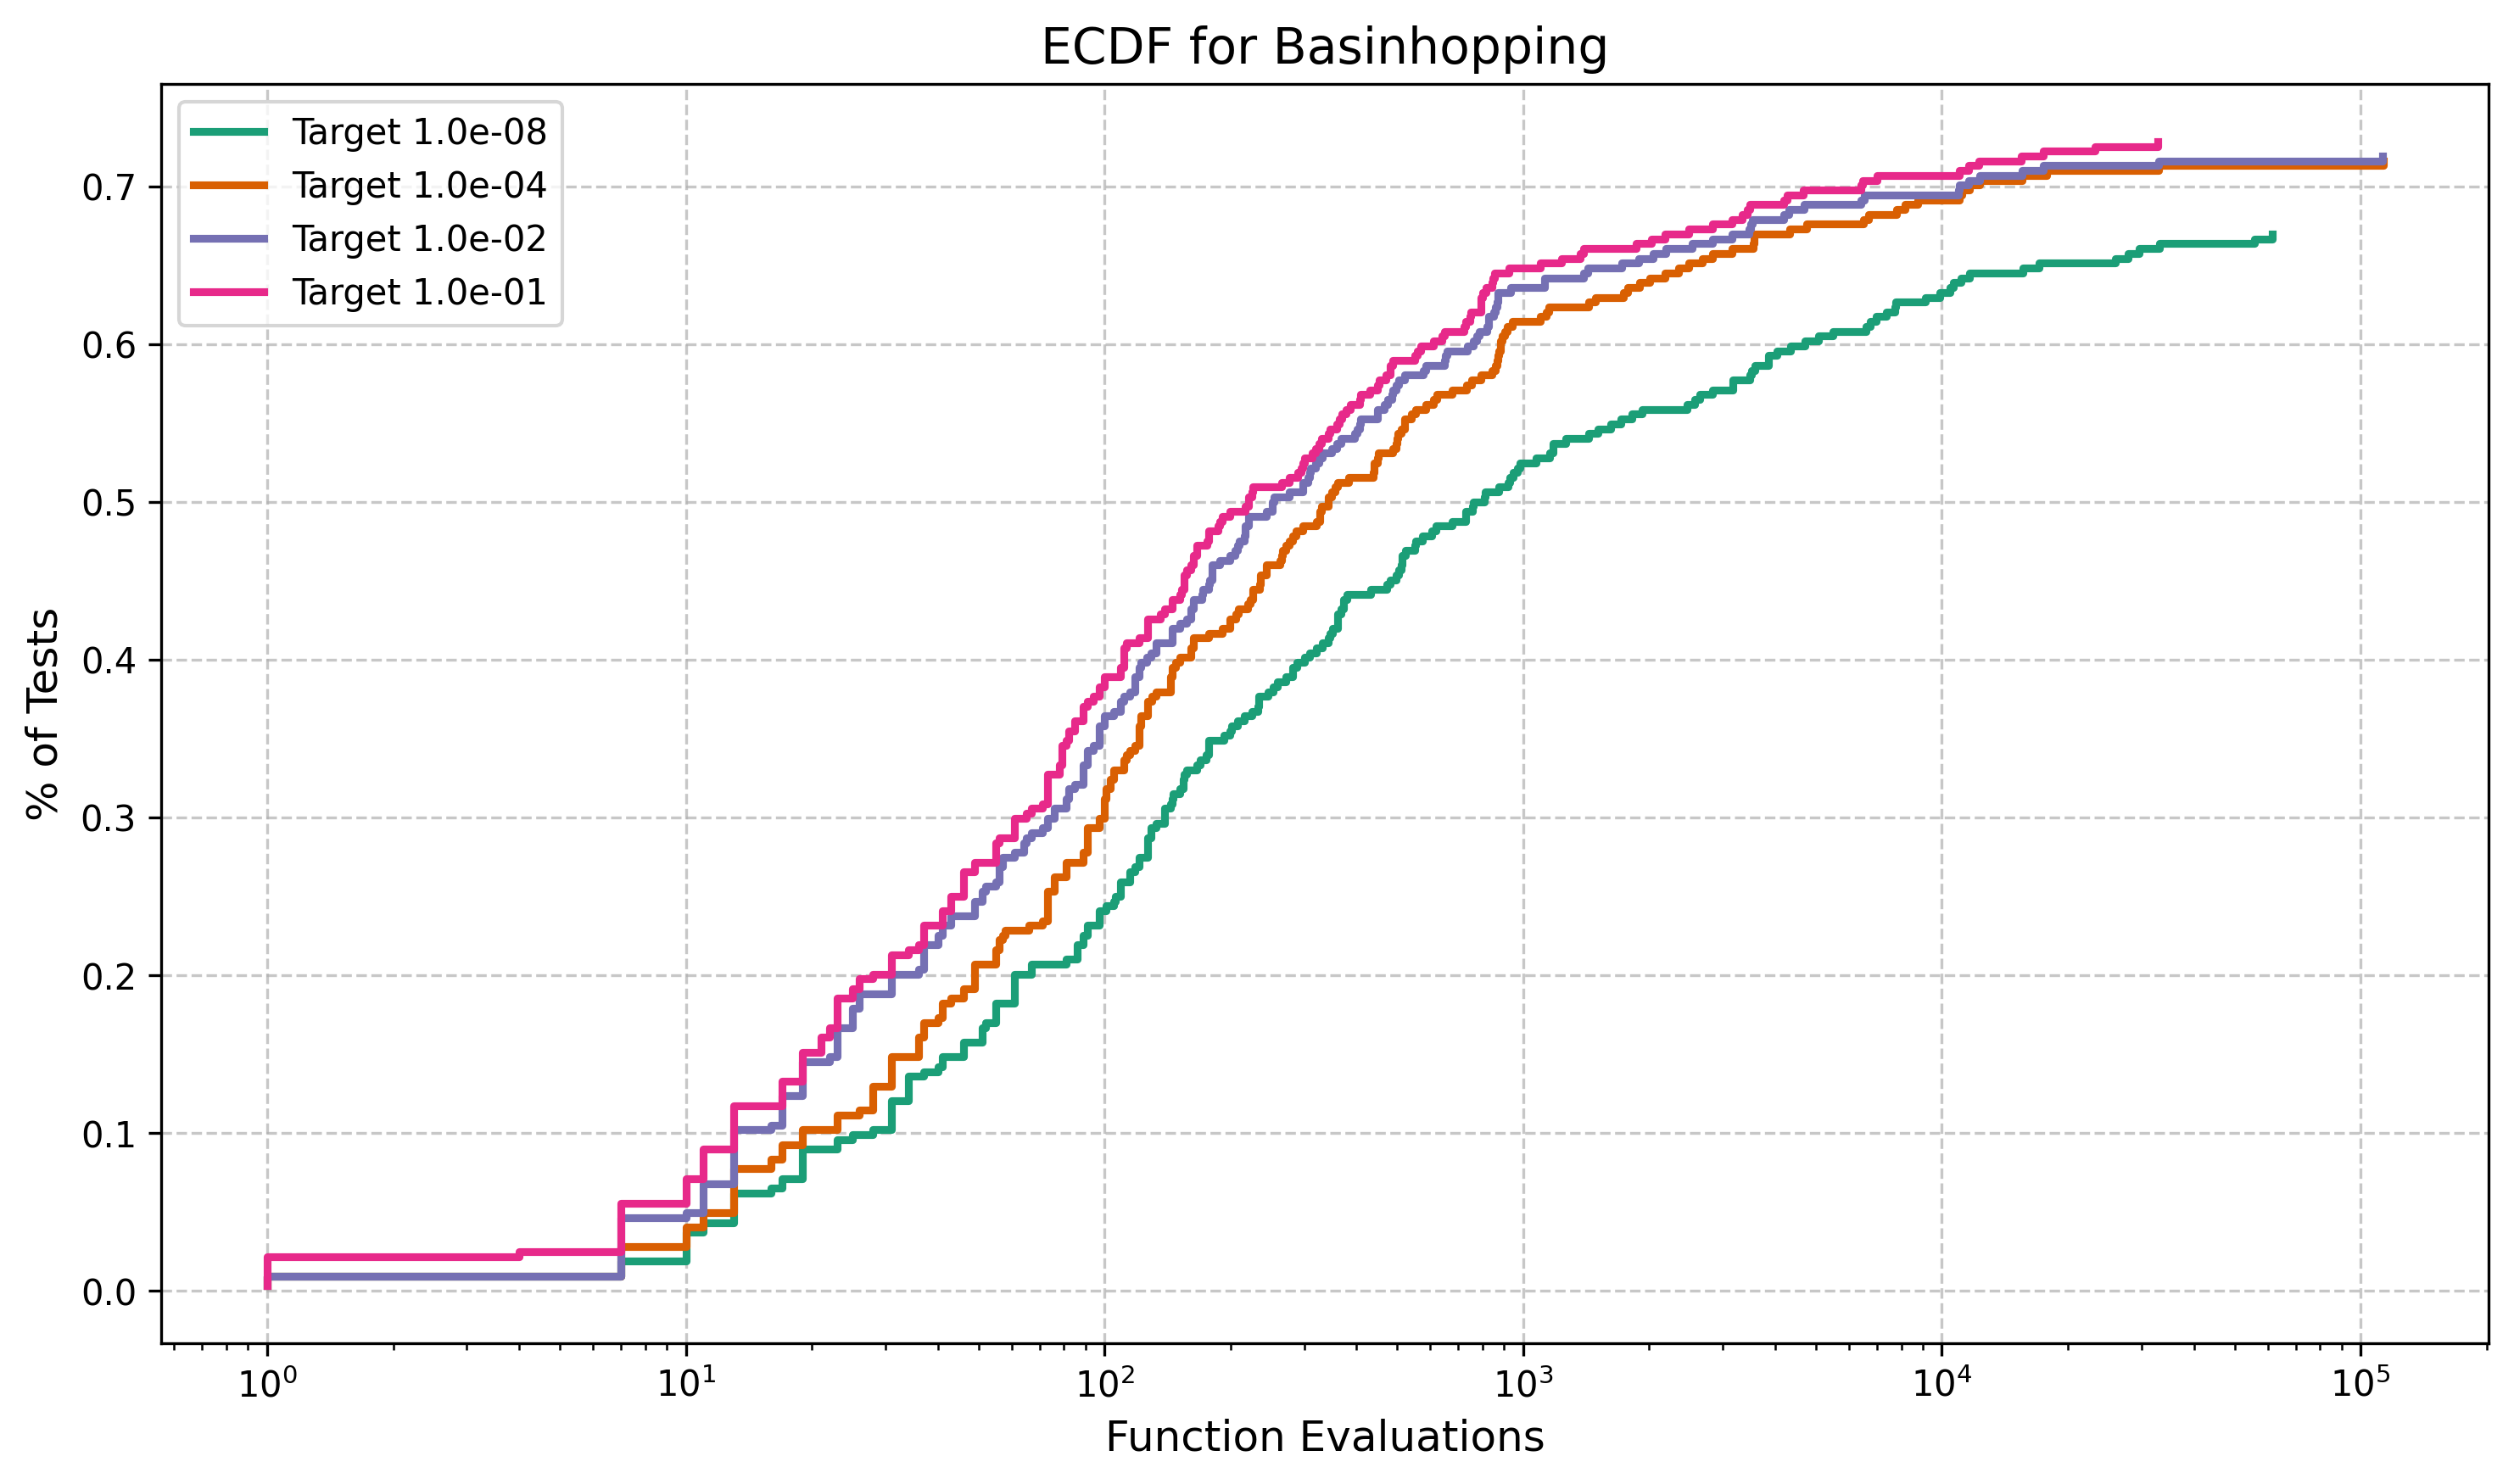

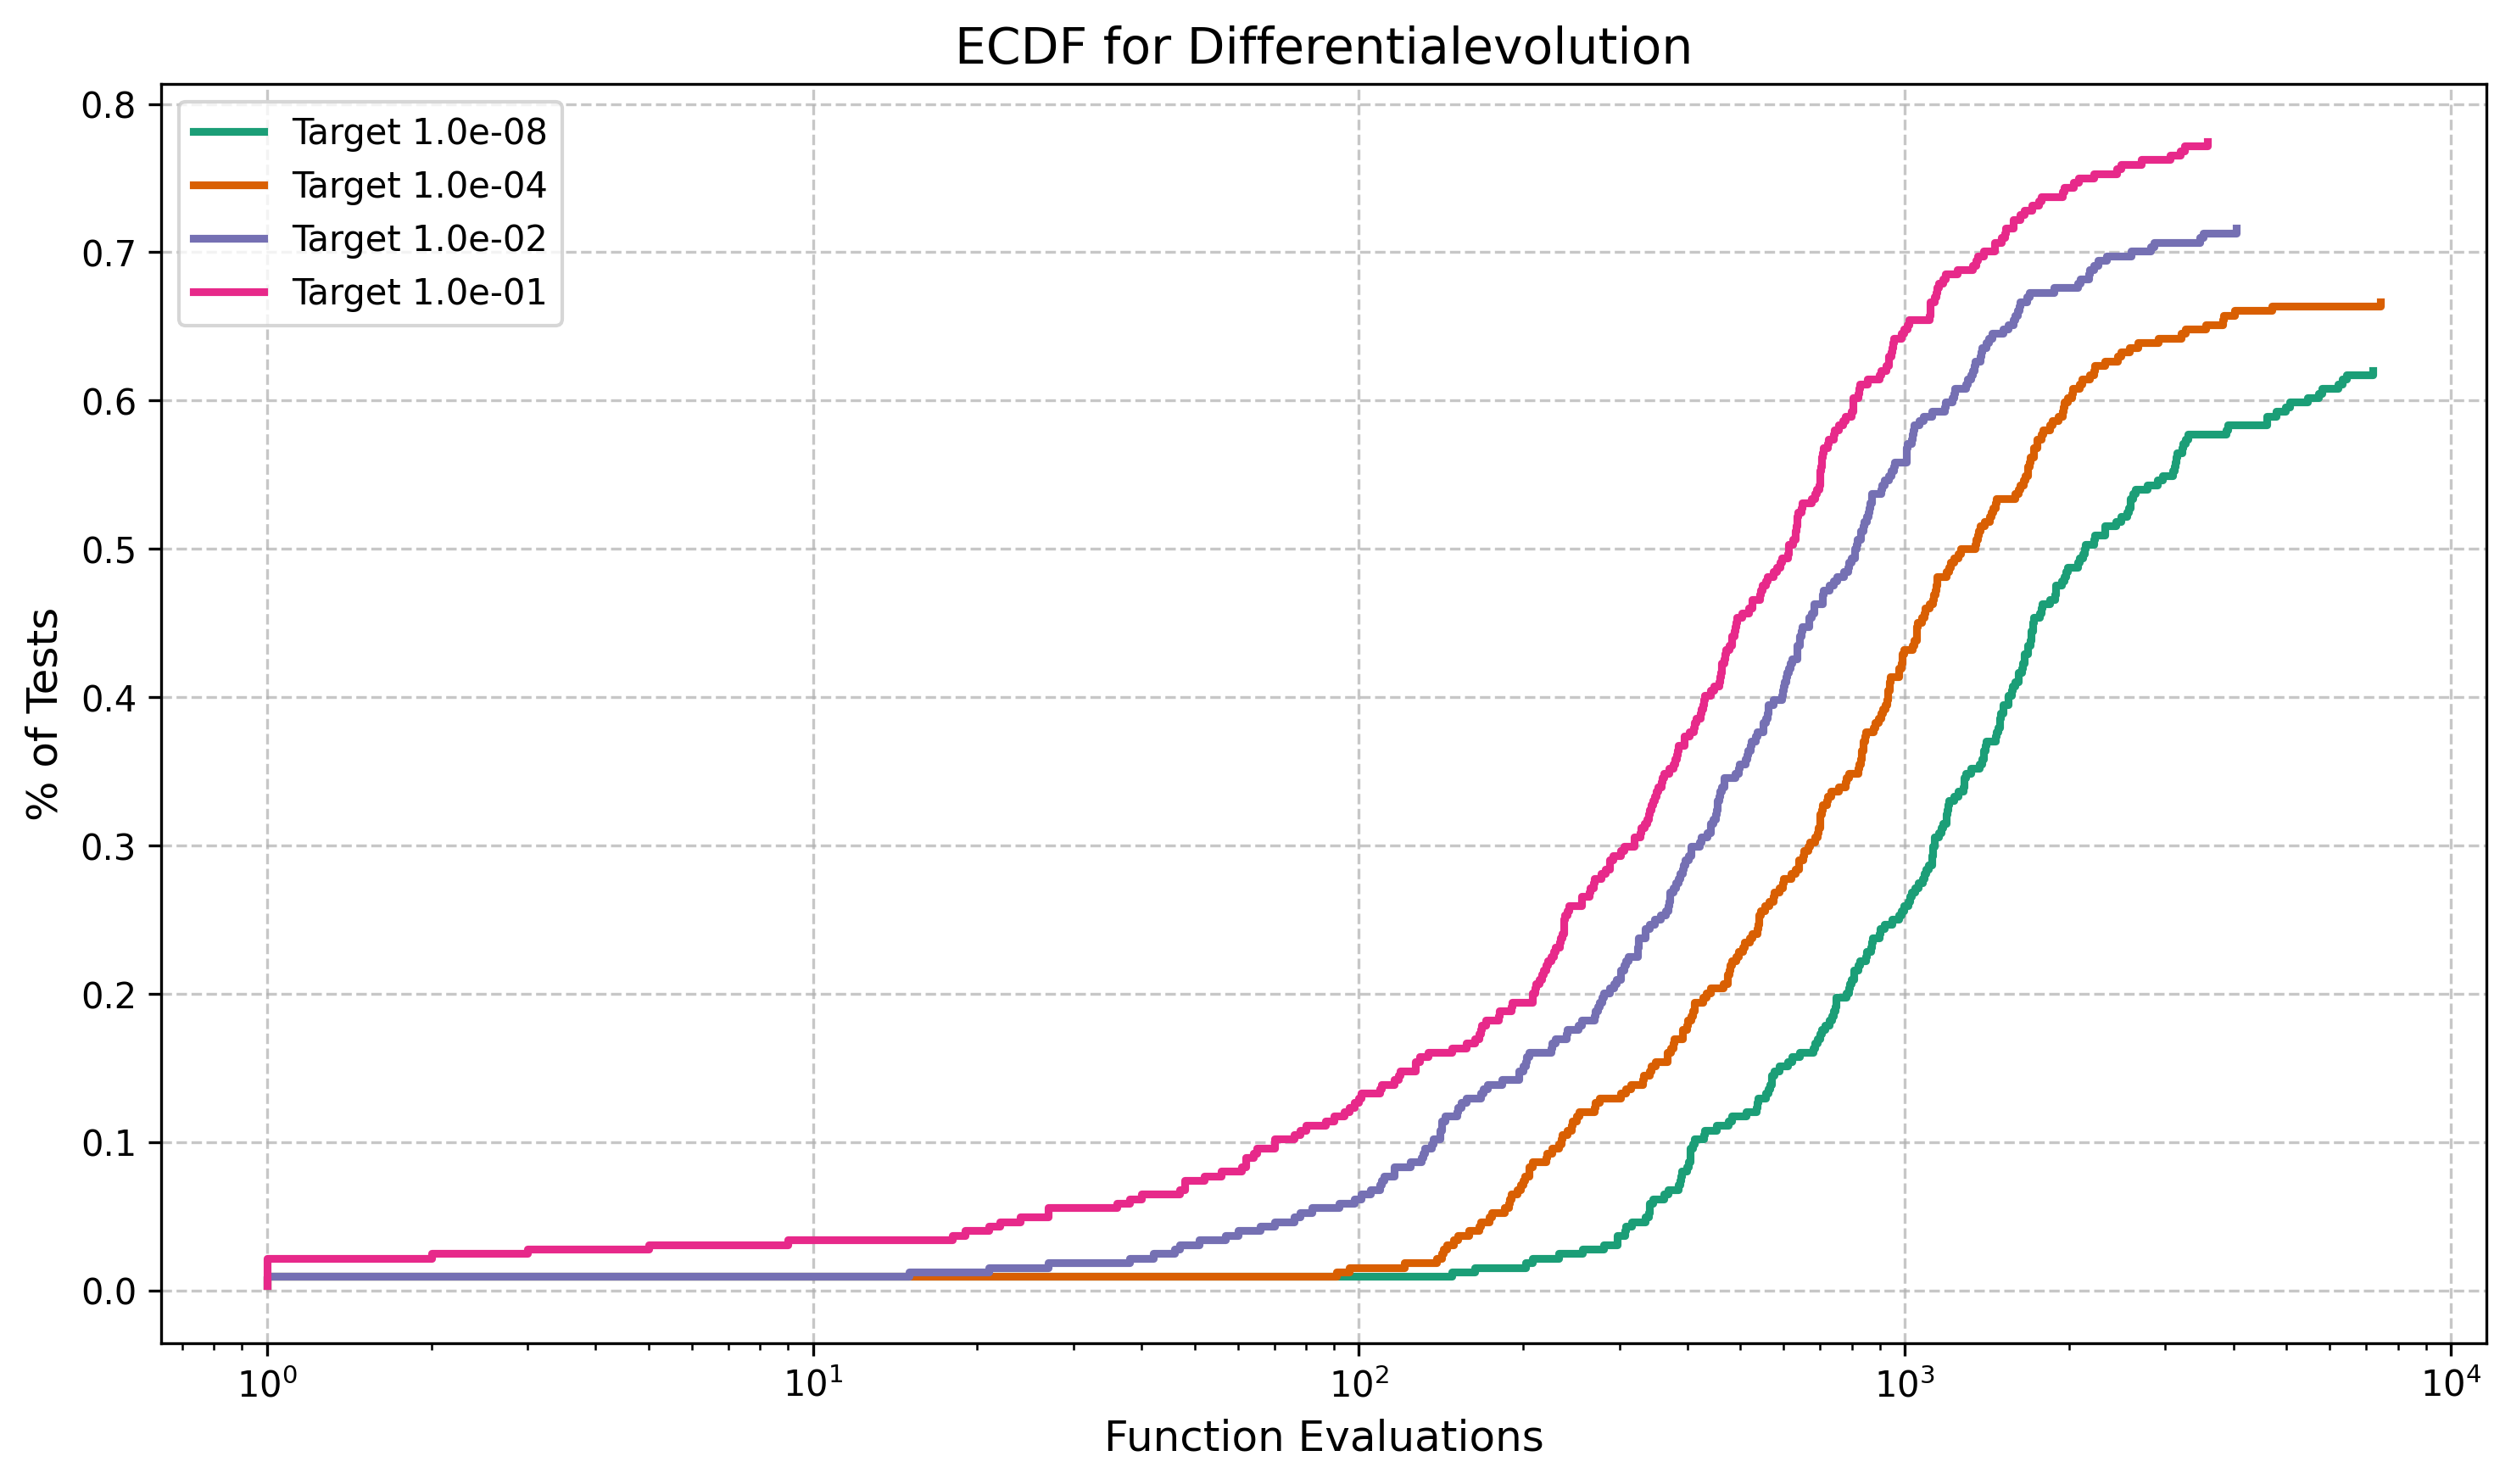

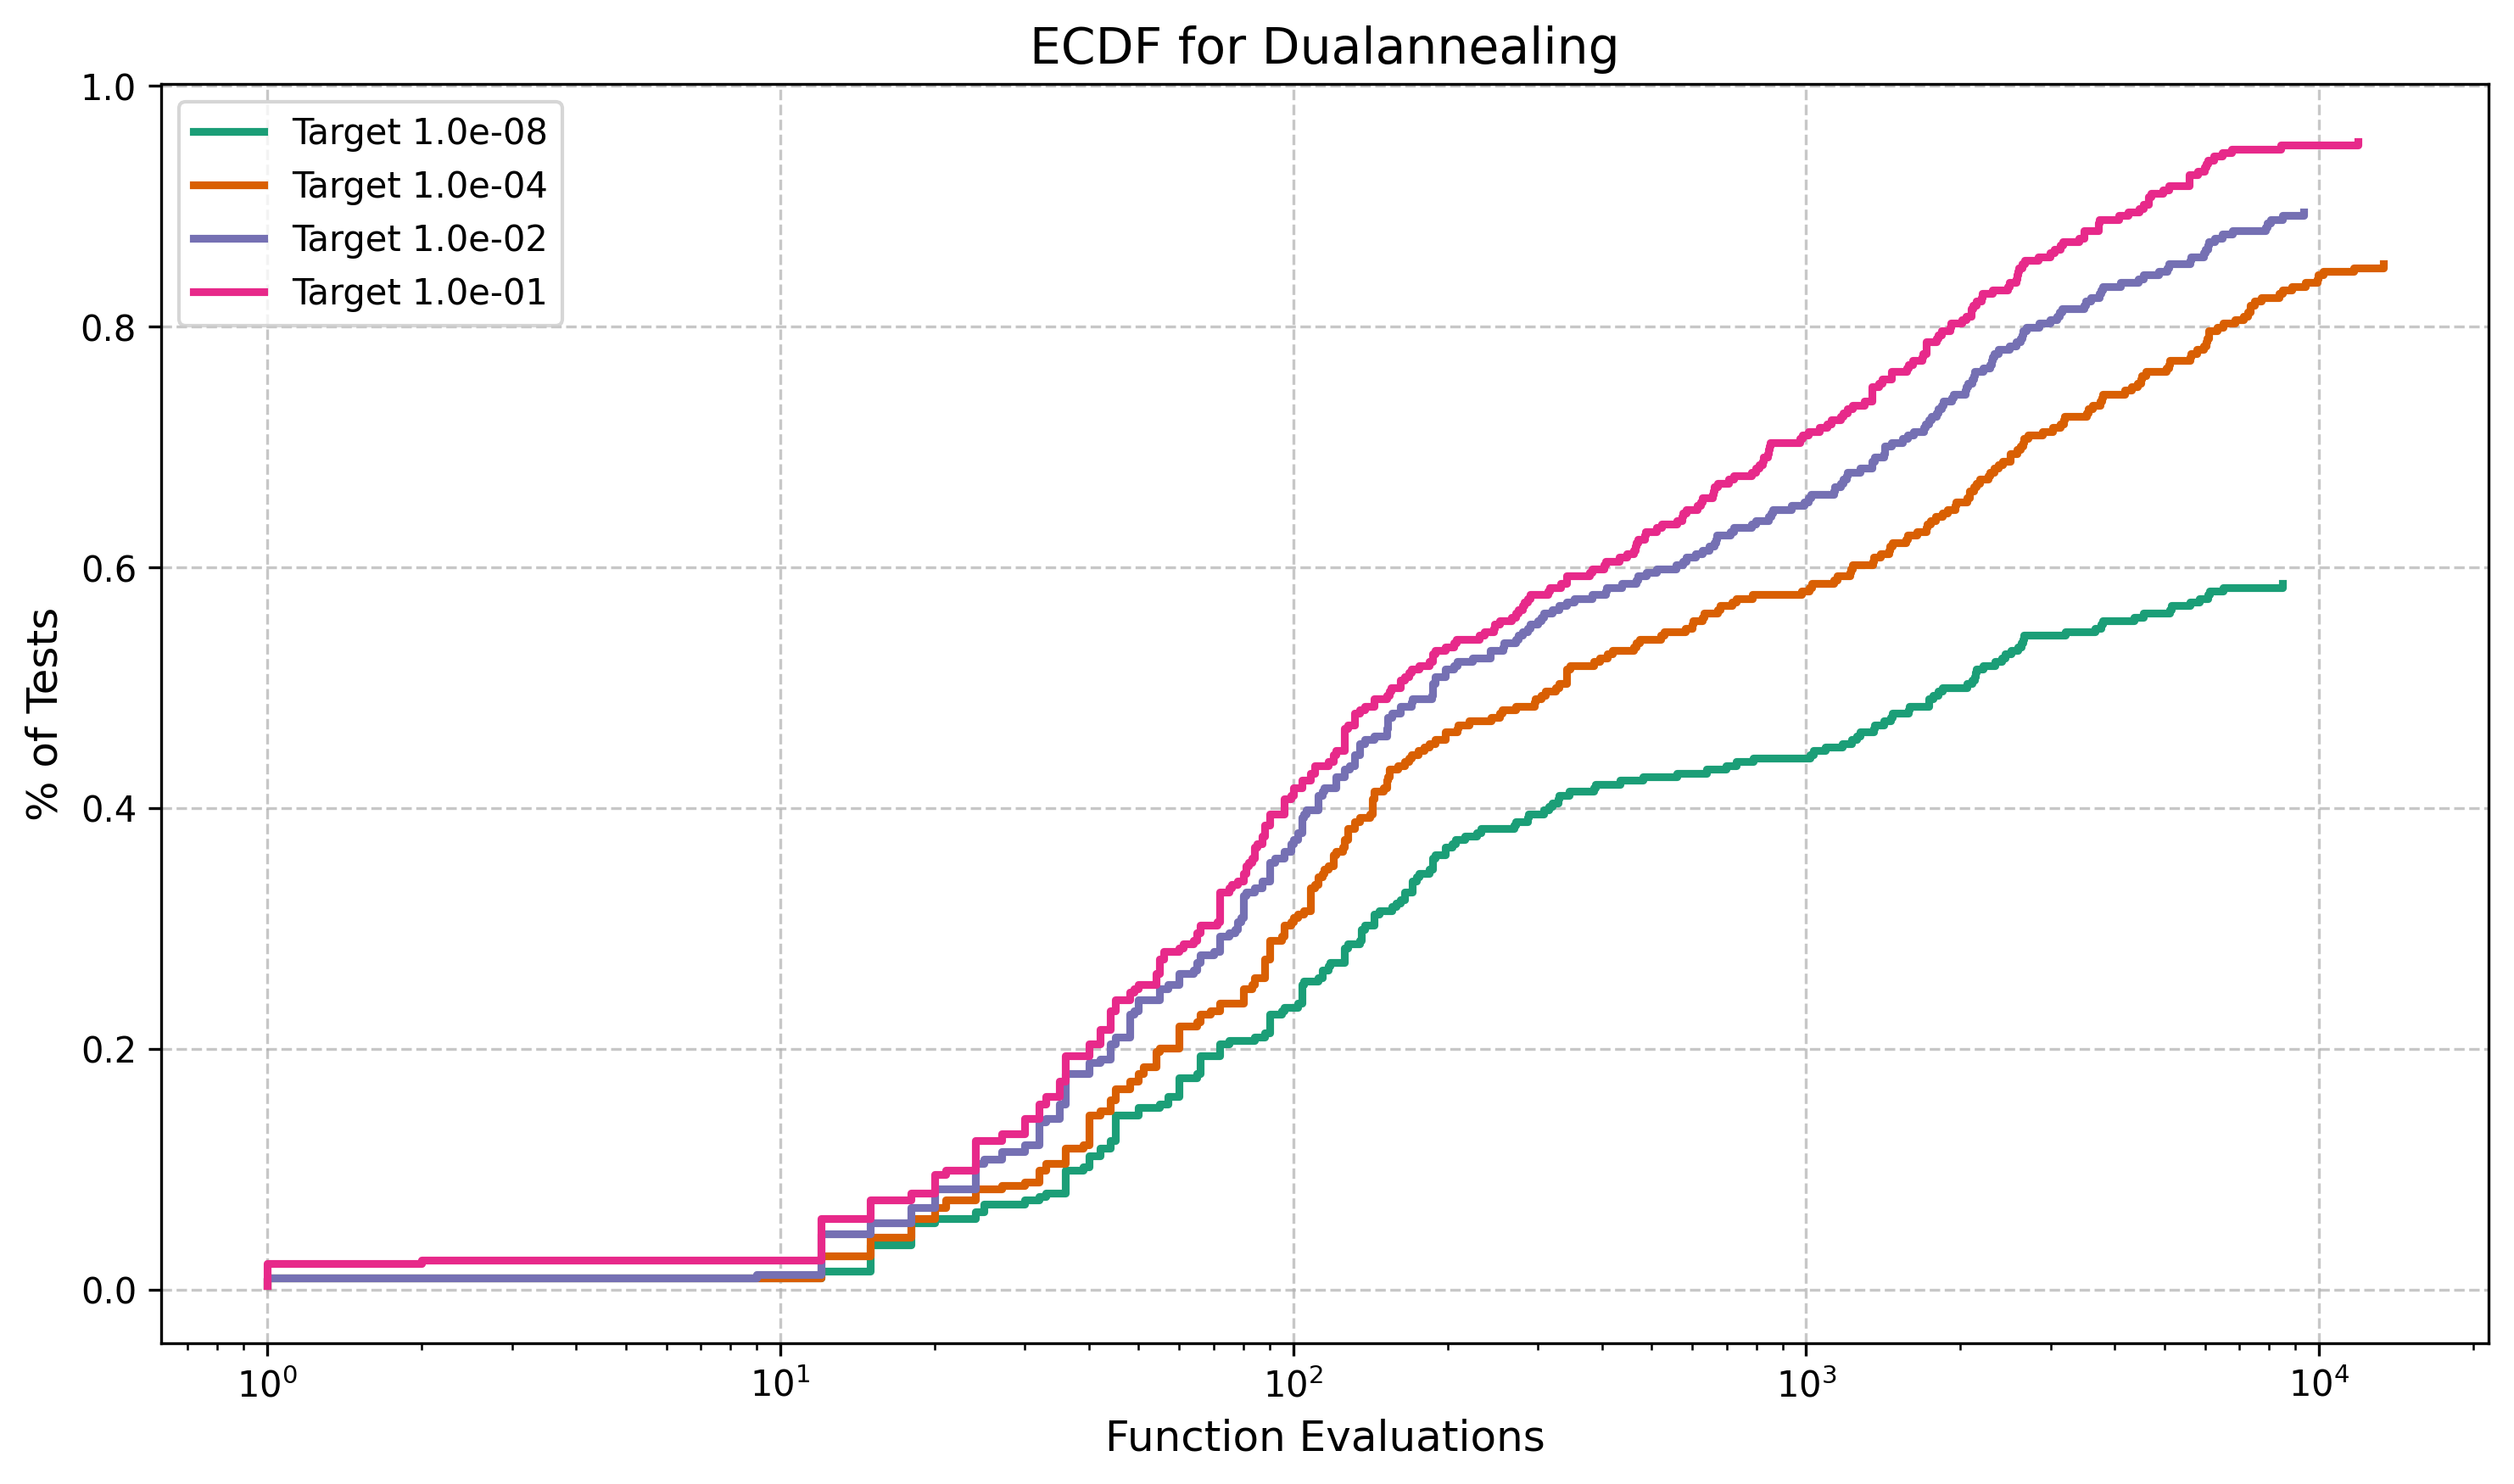

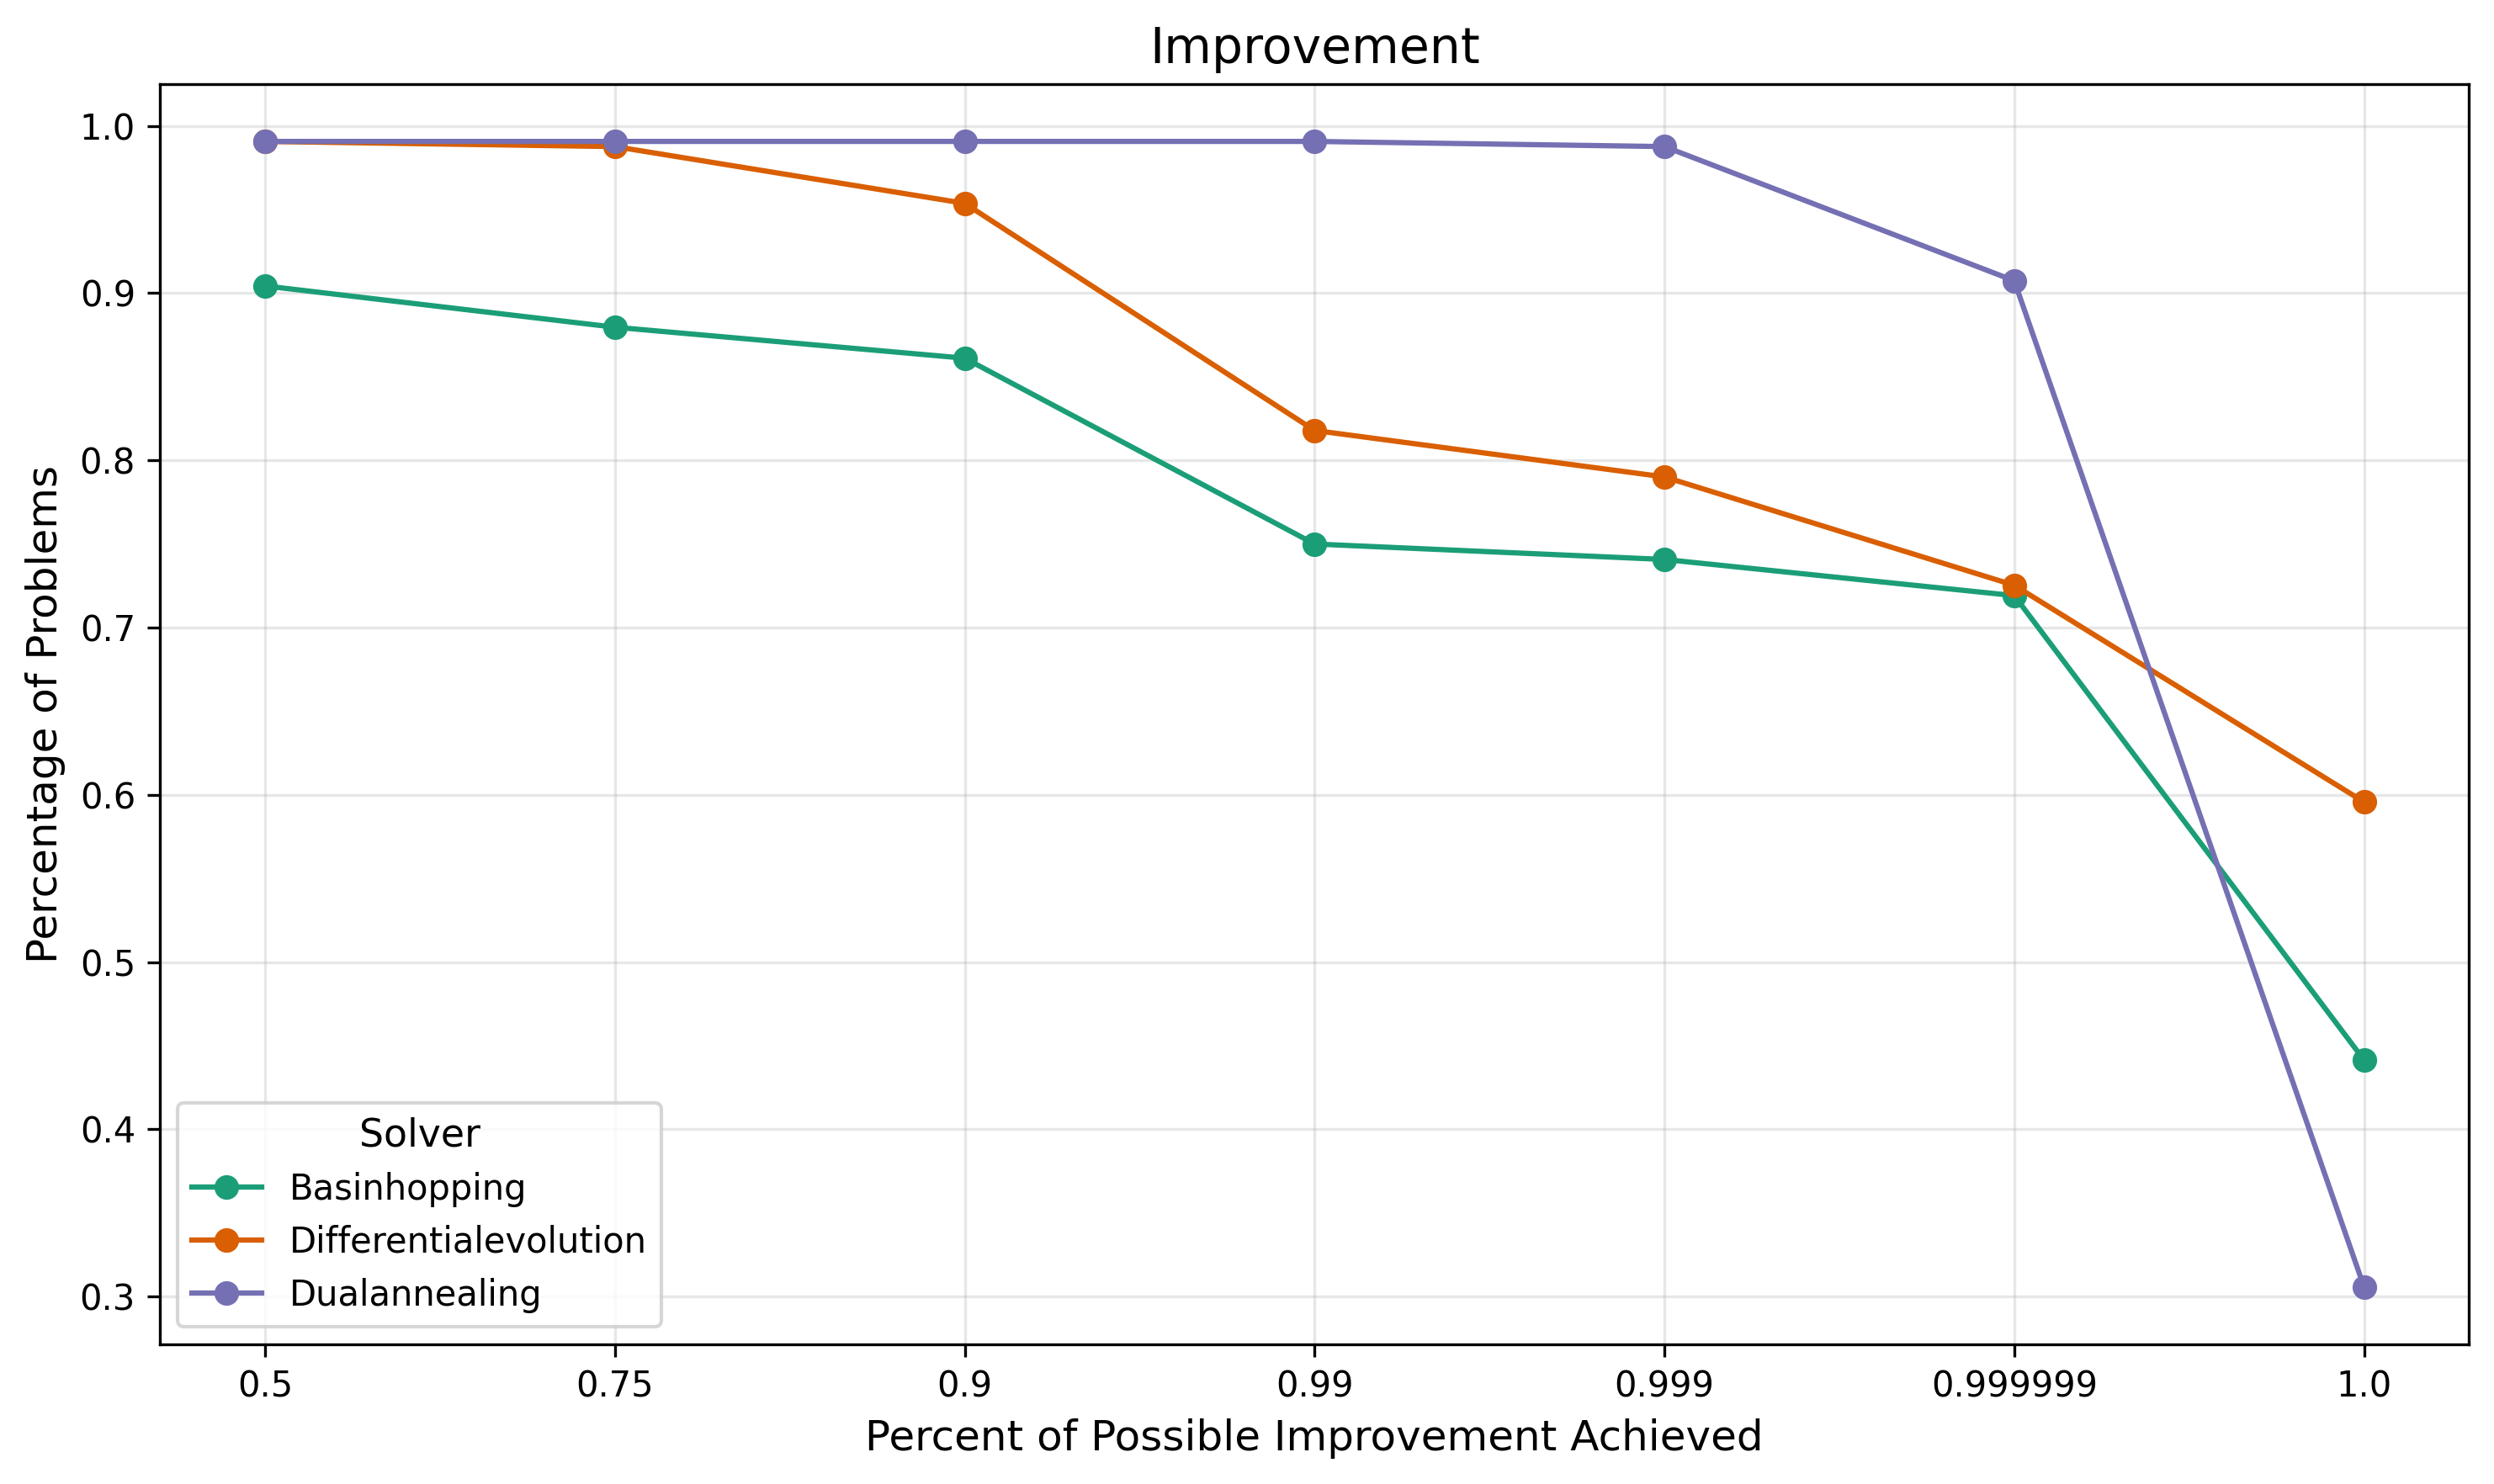

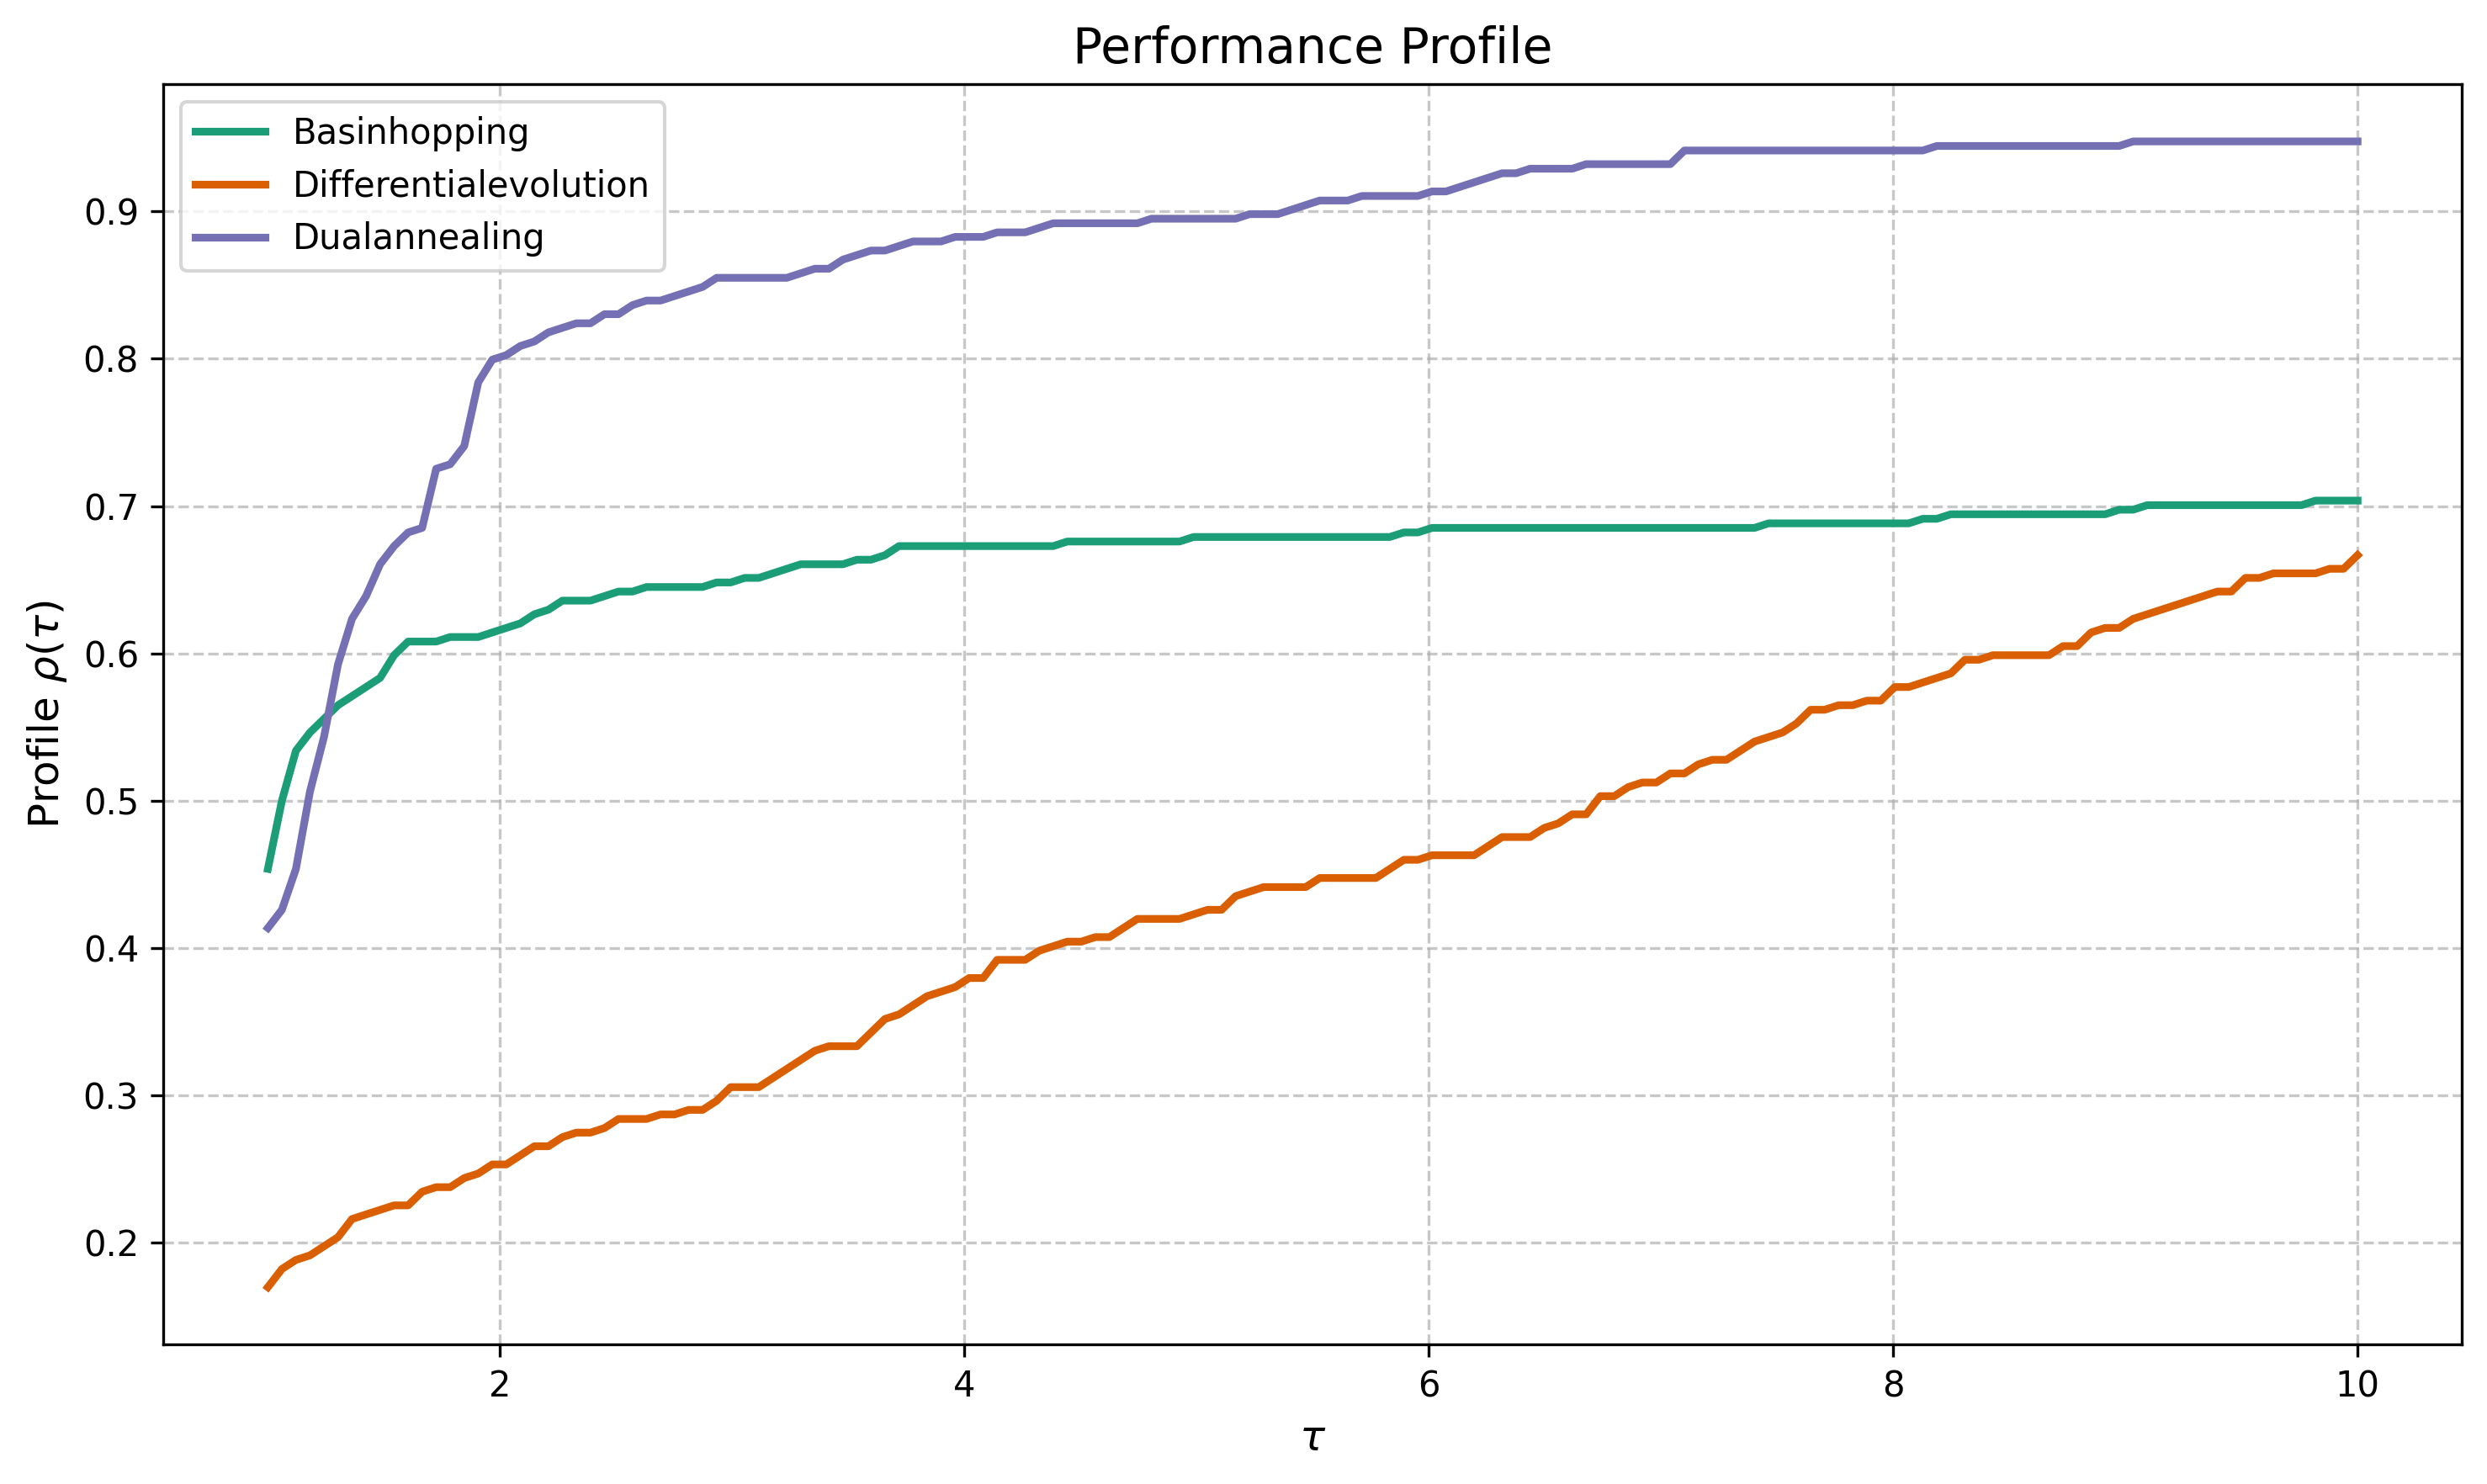

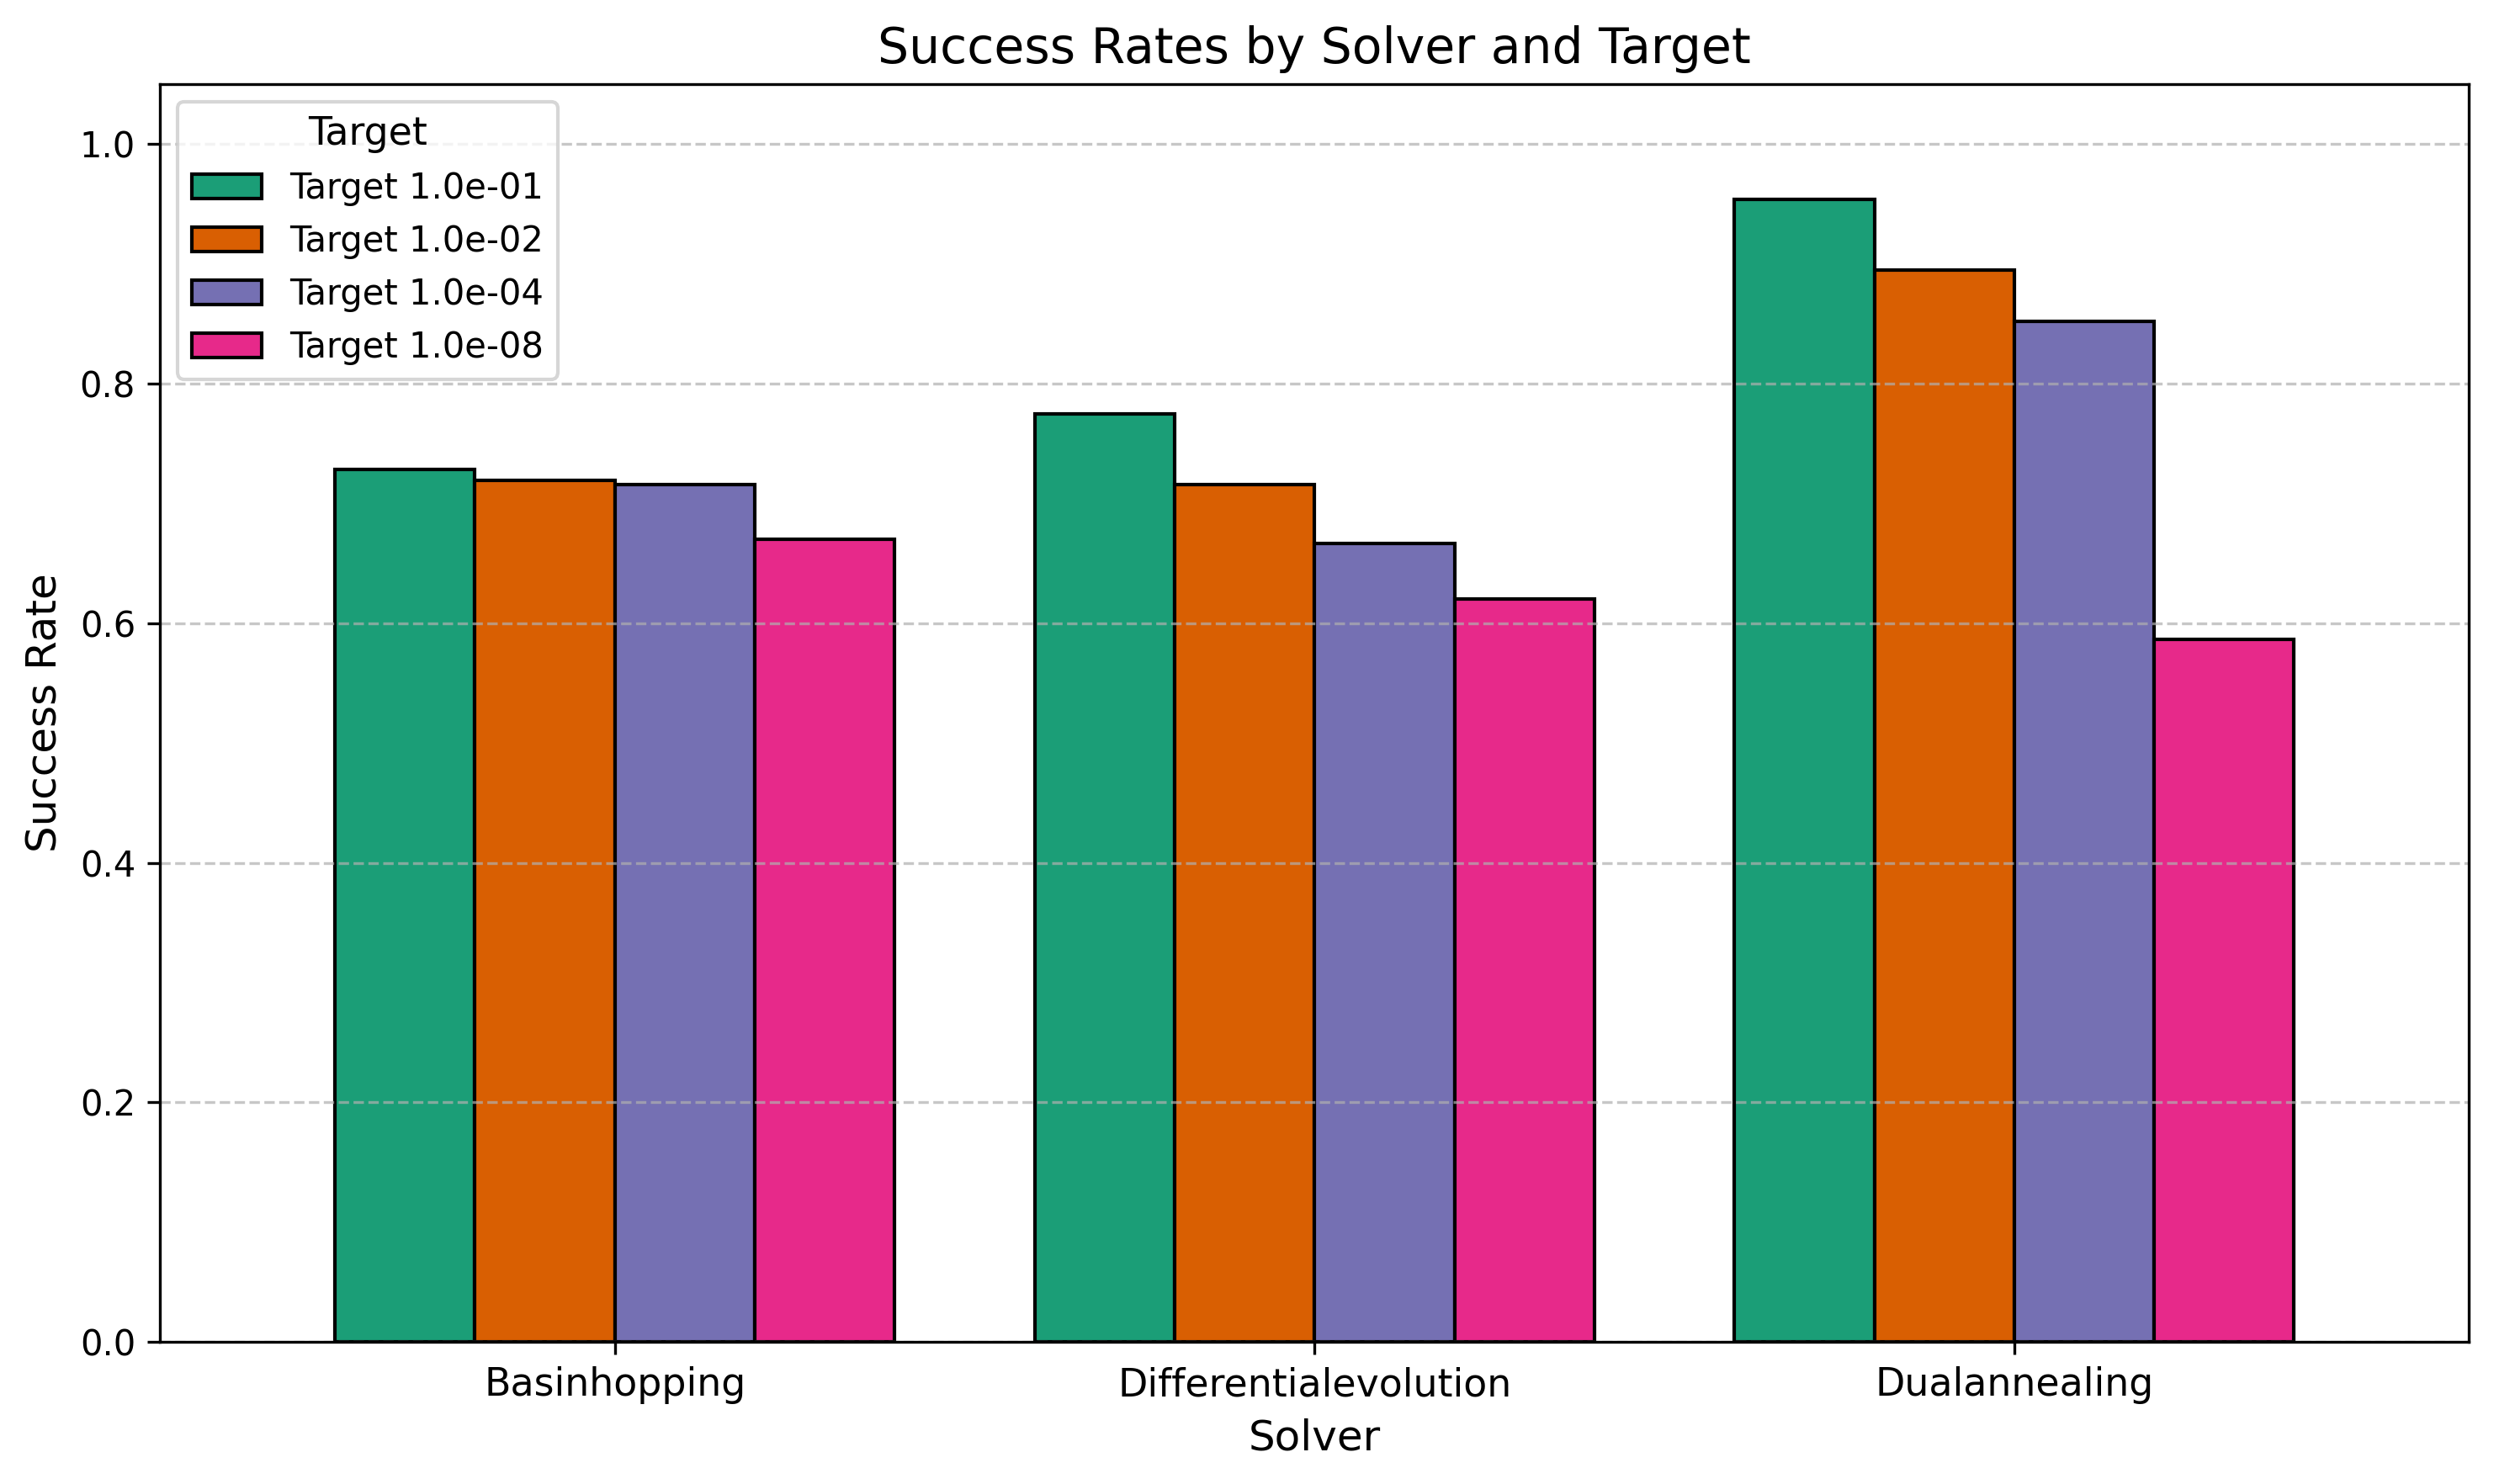

## Average fevals per problem among successful runs:

,problem,solver,n_dims,target_0.1,target_0.01,target_0.0001,target_1e-08
0,Ackley,BasinHopping,2,476.000000,488.000000,527.000000,597.333333
1,Ackley,BasinHopping,4,1884.333333,1909.333333,2004.333333,3276.333333
2,Ackley,BasinHopping,5,2275.000000,2299.000000,2413.000000,4539.000000
3,Ackley,BasinHopping,7,2333.000000,2365.000000,2517.000000,6966.000000
4,Ackley,BasinHopping,8,6472.000000,6517.000000,6679.000000,6980.000000
...,...,...,...,...,...,...,...
319,Zakharov,DualAnnealing,4,48.333333,58.333333,68.333333,76.666667
320,Zakharov,DualAnnealing,5,66.000000,80.000000,94.000000,104.000000
321,Zakharov,DualAnnealing,7,77.333333,93.333333,106.666667,120.000000
322,Zakharov,DualAnnealing,8,117.000000,150.000000,174.000000,189.000000


In [4]:
# Path to the figures
figure_path = "ppfigures/fevals"

# Get all figure files in the directory
figure_files = glob.glob(os.path.join(figure_path, "*.png"))
figure_files.sort()

# Display each figure
for fig_file in figure_files:
    display(Image(filename=fig_file, width=1000))

# Display dataframe
display(Markdown("## Average fevals per problem among successful runs:"))
display(results['data']['mean_fevals'])

And the energy usage metrics:

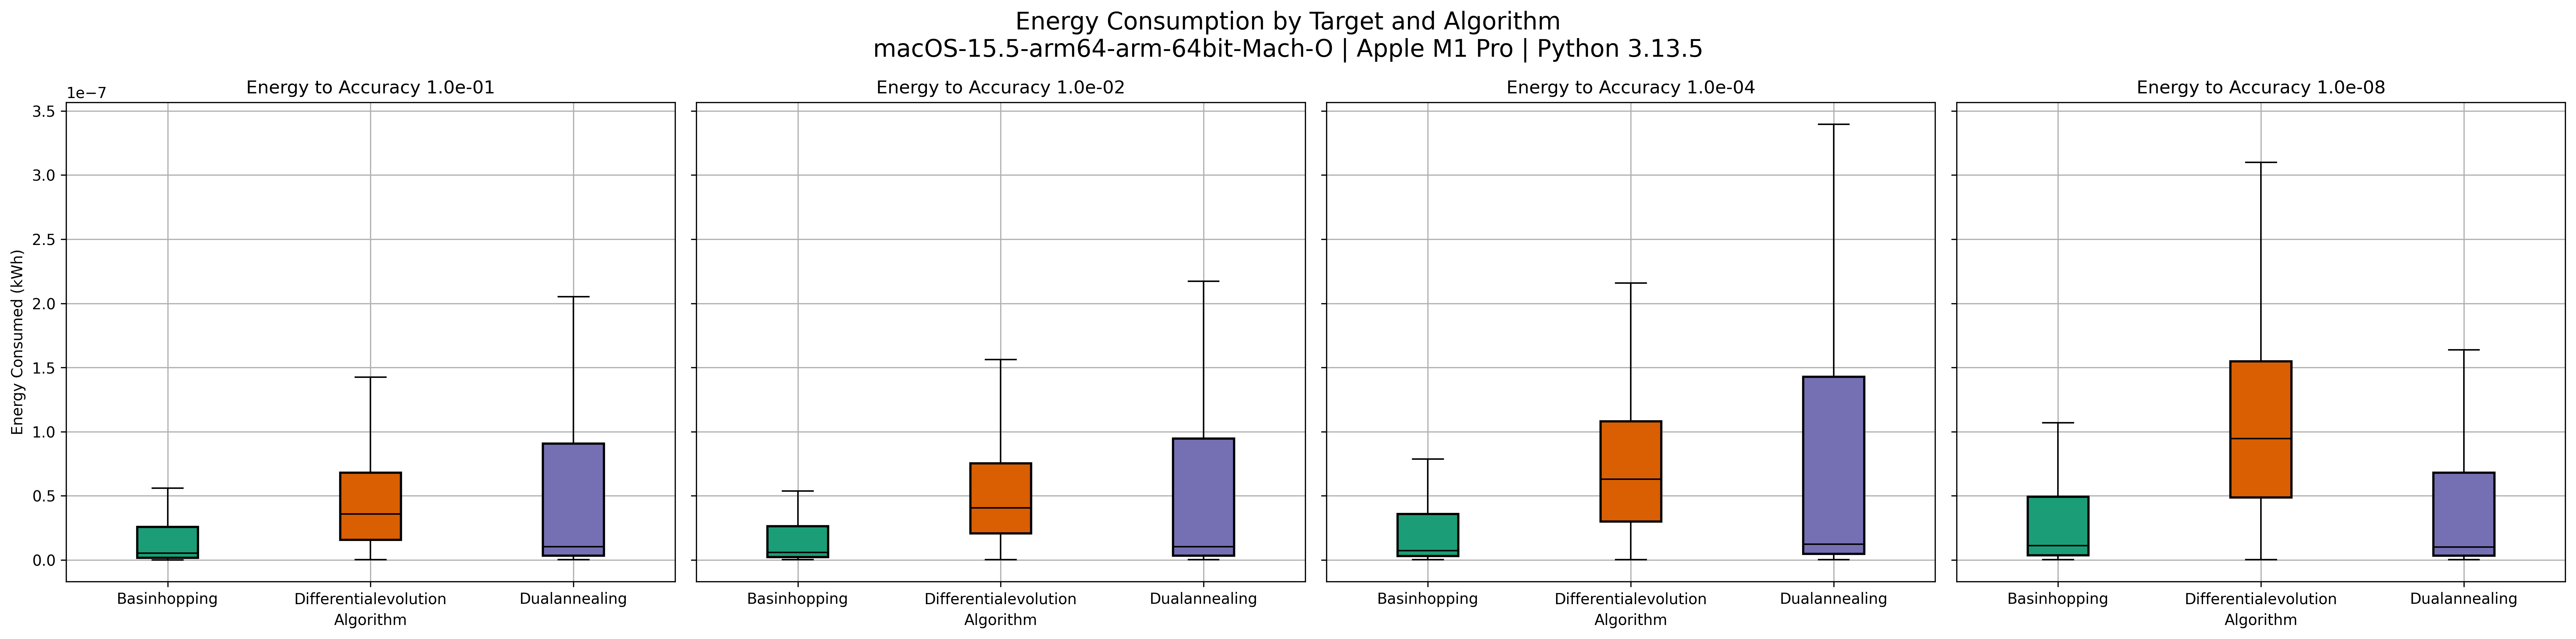

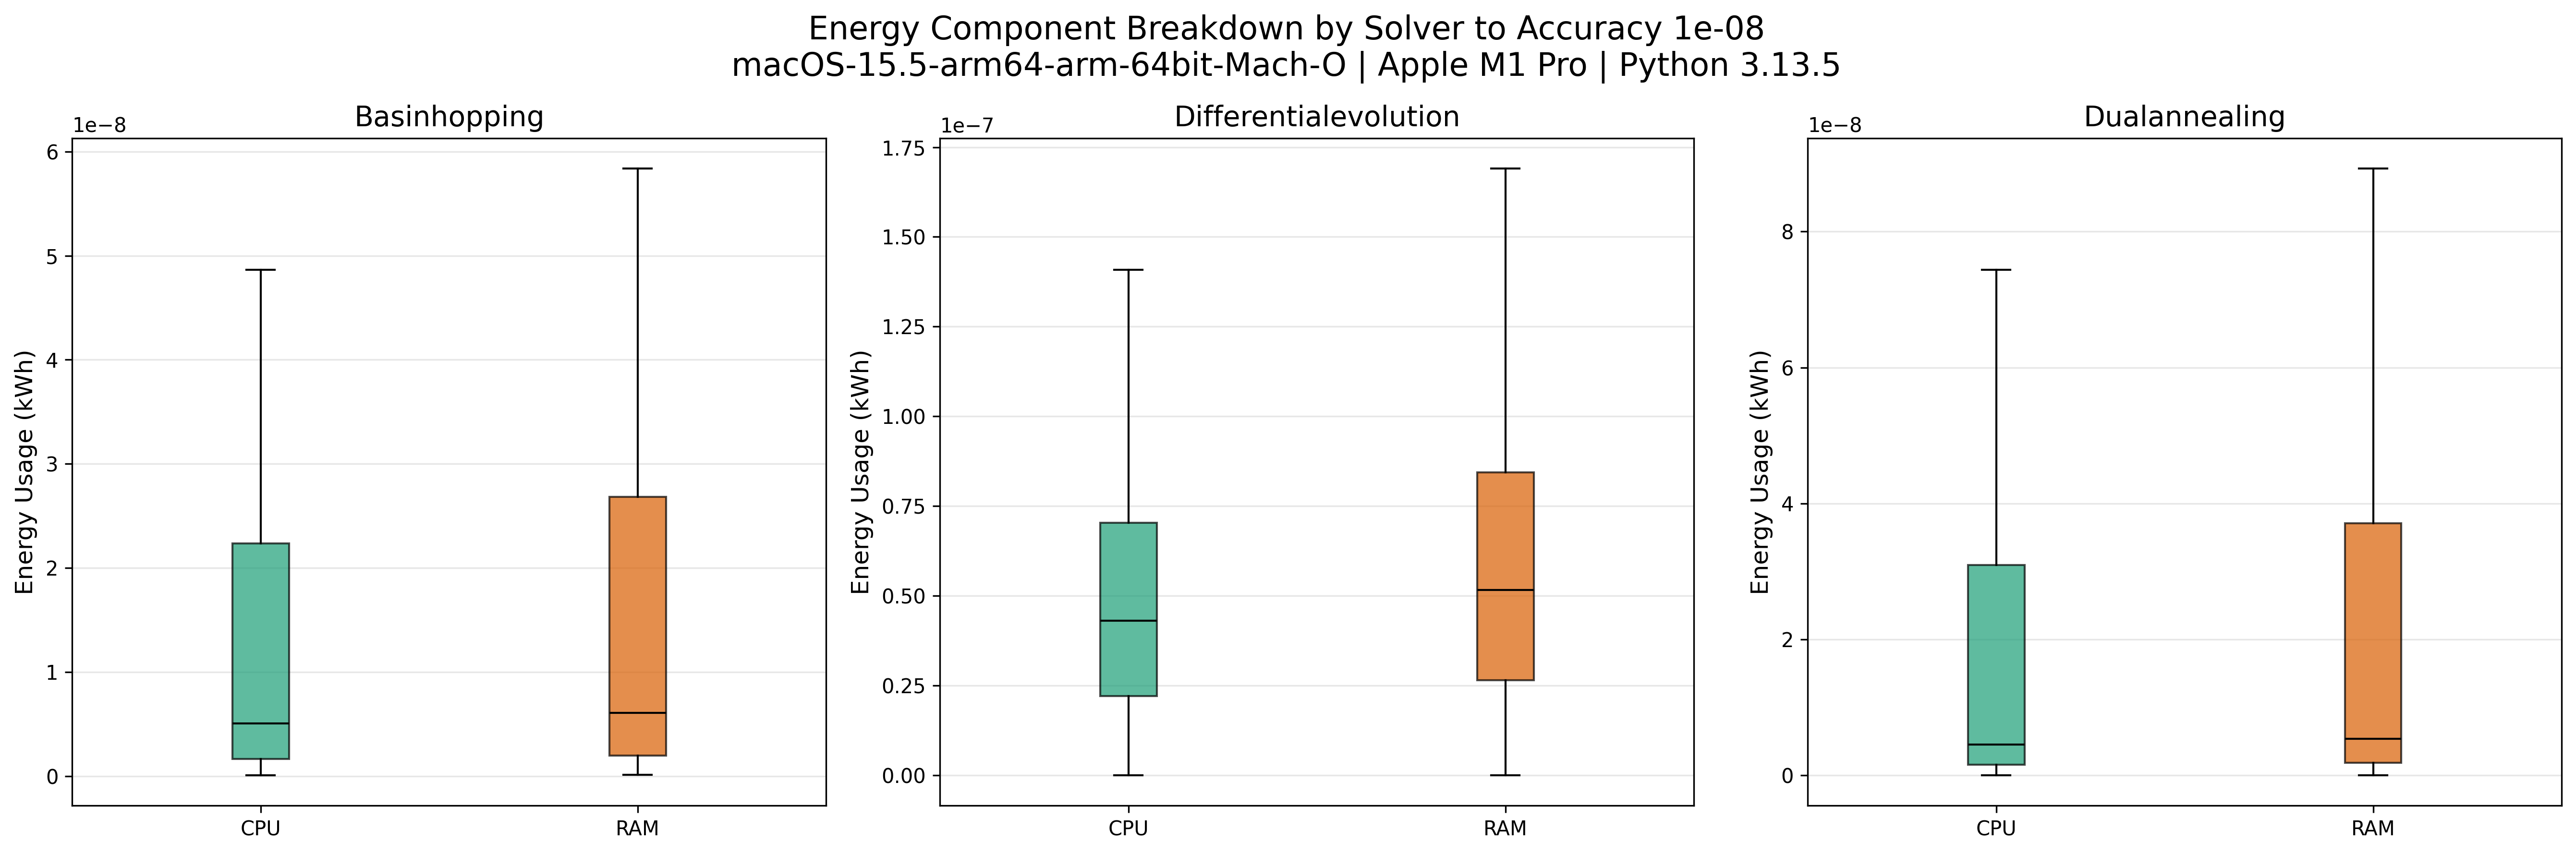

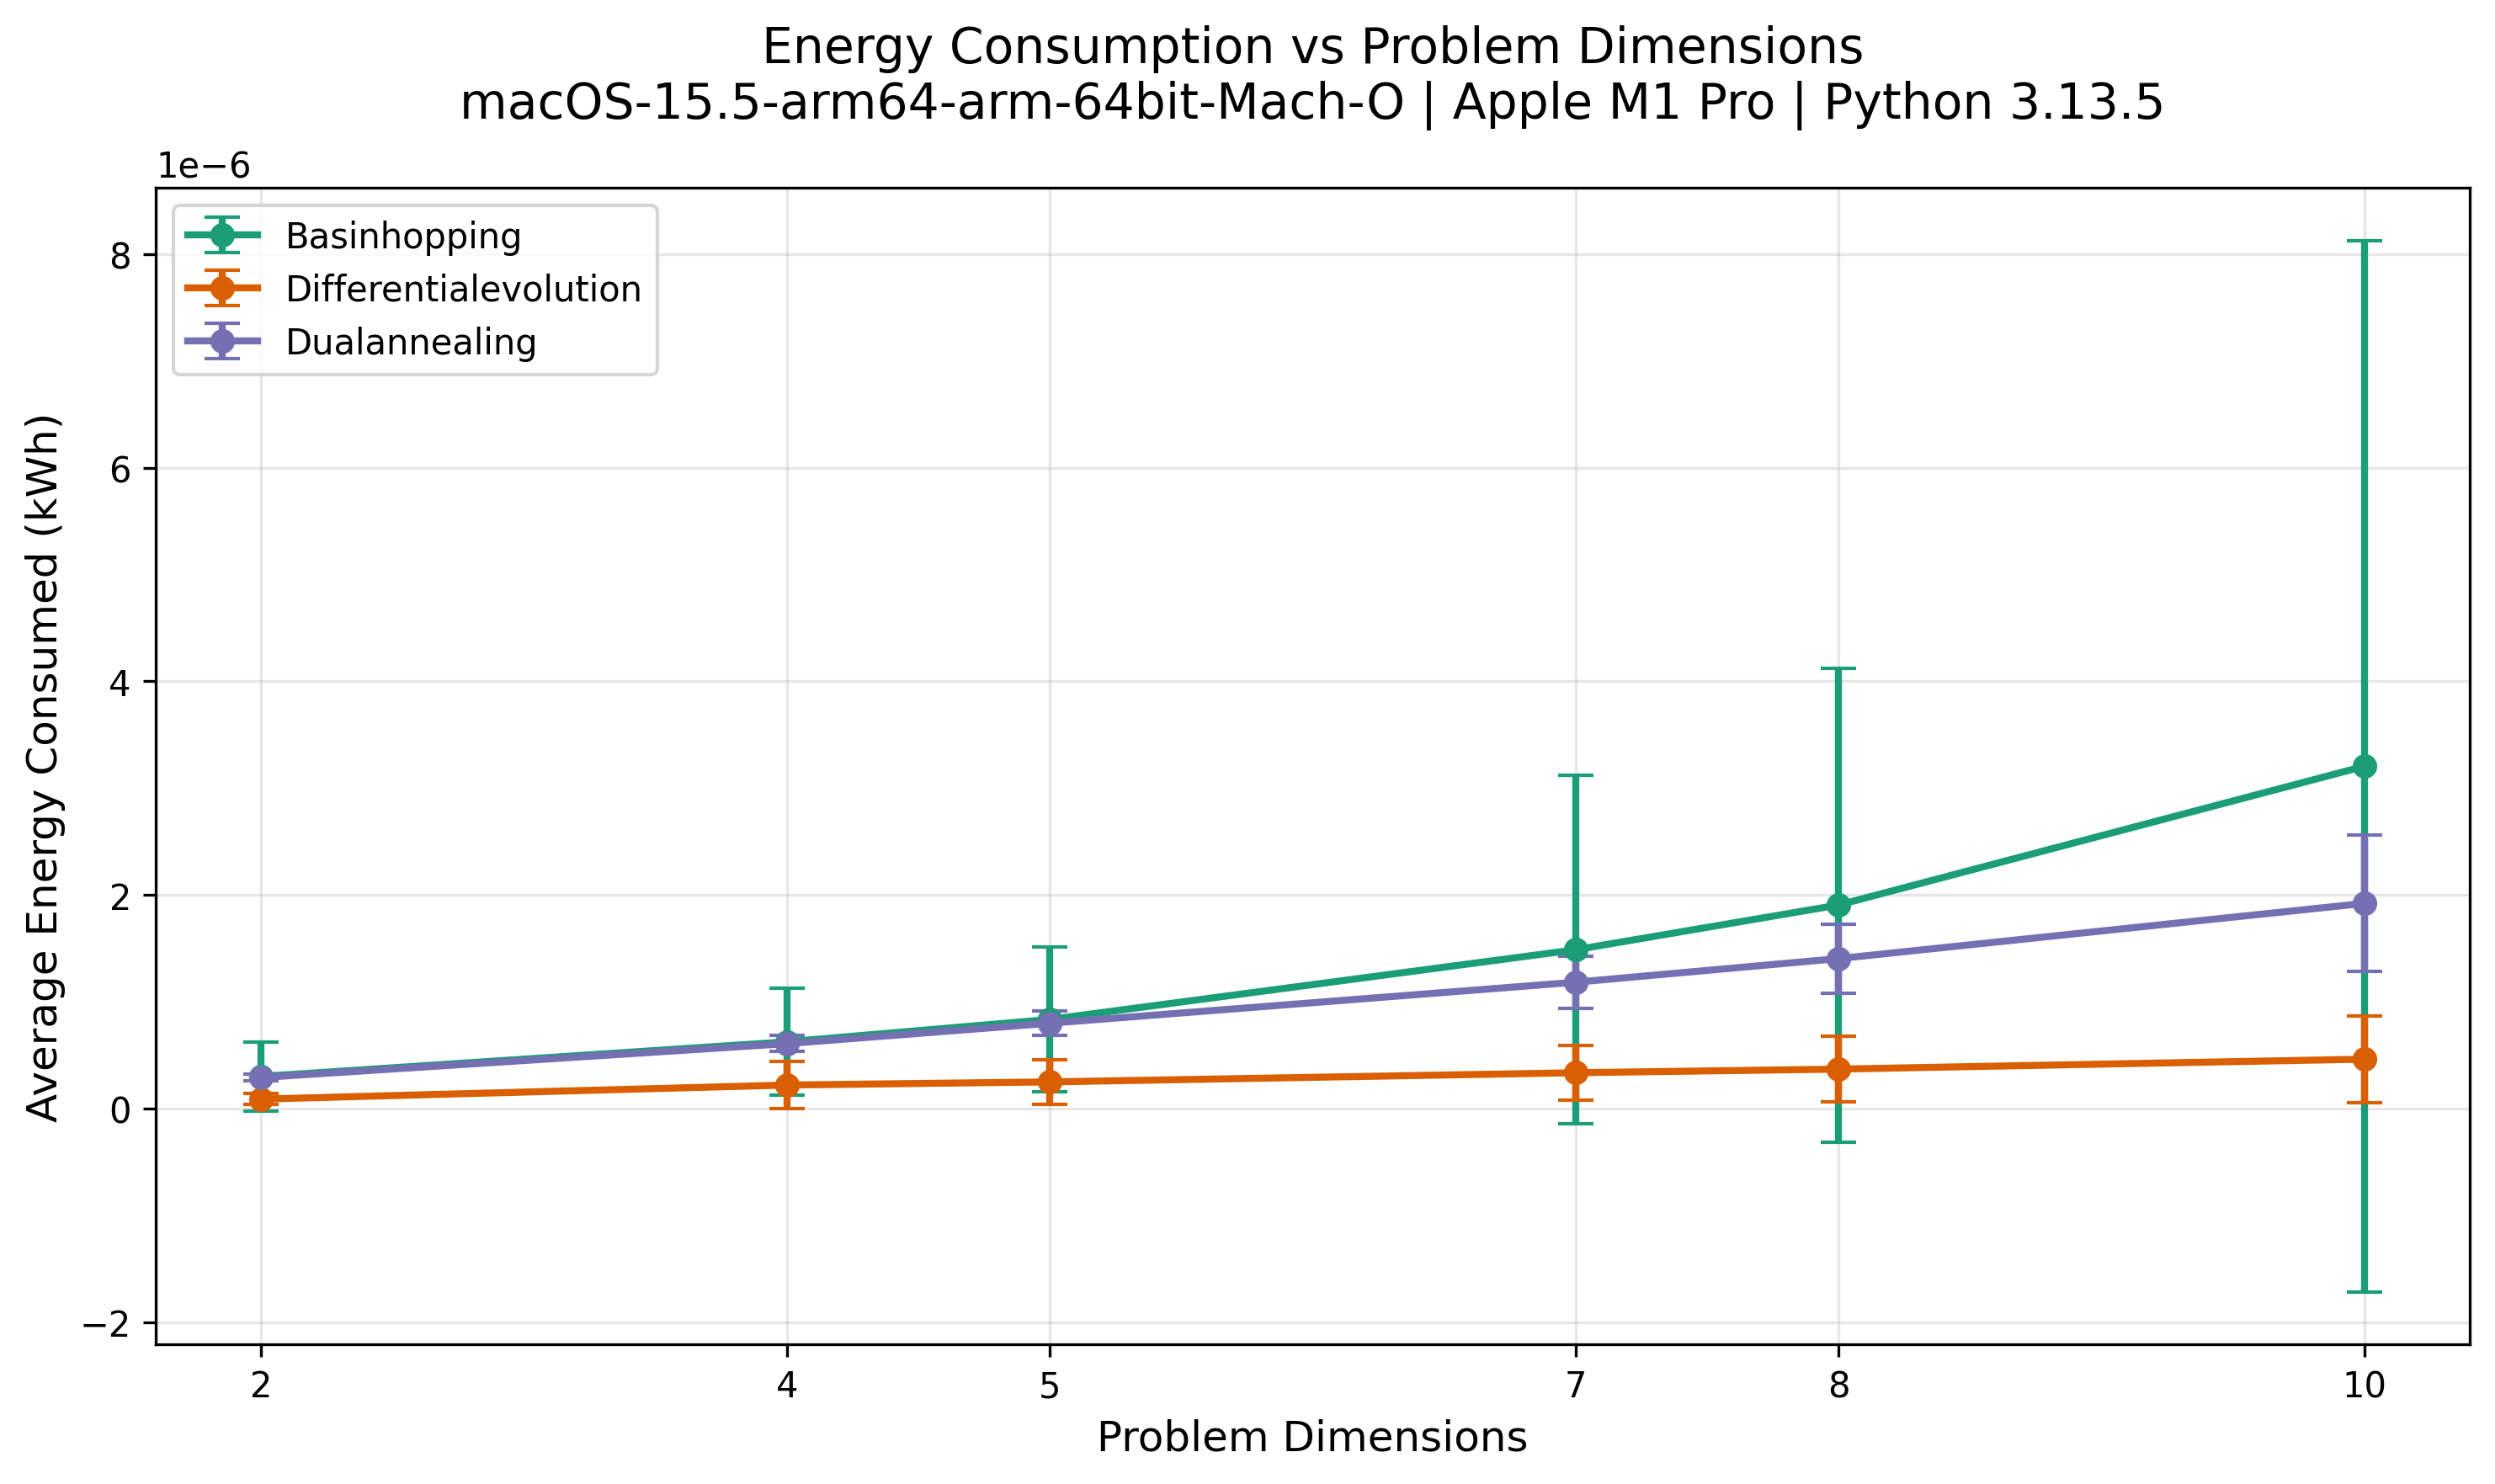

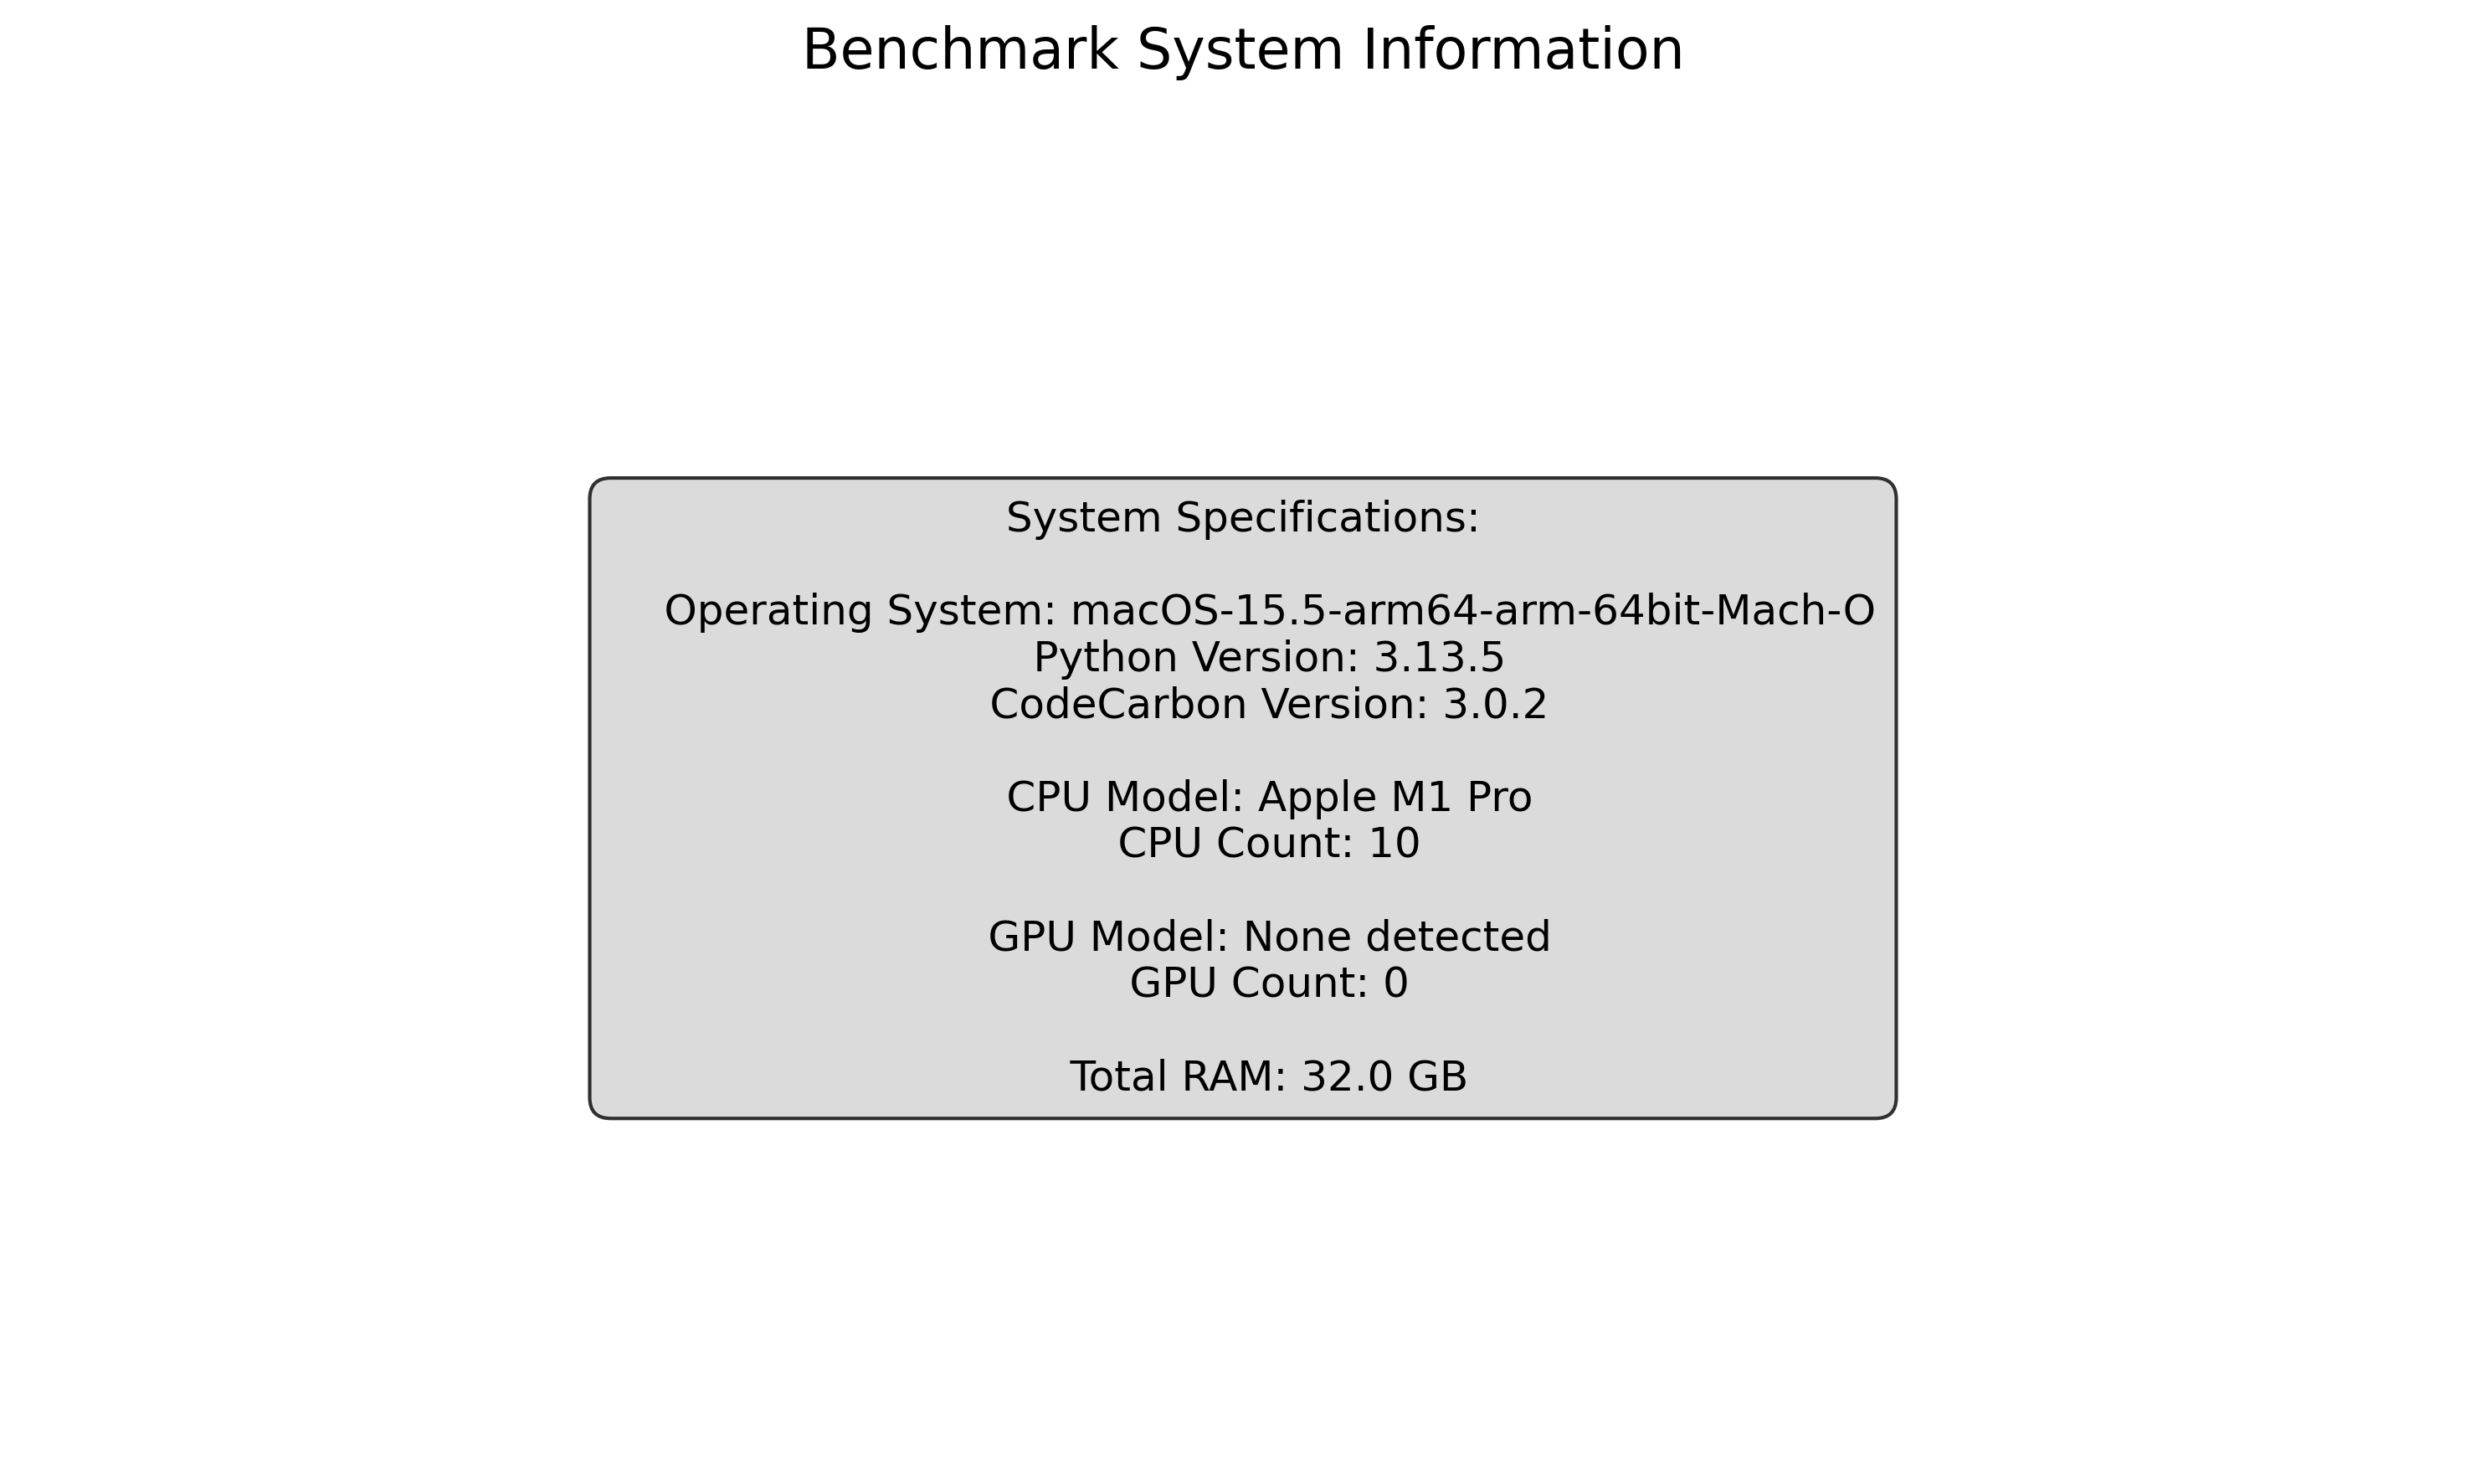

## Summary Energy Statistics:

,energy_consumed_mean,energy_consumed_std,energy_consumed_median,energy_consumed_min,energy_consumed_max,cpu_energy_mean,gpu_energy_mean,ram_energy_mean
Basinhopping,1.394144e-06,2.509033e-06,7.002328e-07,5.650056e-08,0.000018,6.337461e-07,0.0,7.603978e-07
Differentialevolution,2.889168e-07,2.882538e-07,1.687085e-07,3.780892e-09,0.000001,1.313670e-07,0.0,1.575497e-07
Dualannealing,1.035567e-06,6.221934e-07,9.813784e-07,2.449982e-07,0.000004,4.707586e-07,0.0,5.648083e-07


In [7]:
# Path to the figures
figure_path = "ppfigures/energy"

# Get all figure files in the directory
figure_files = glob.glob(os.path.join(figure_path, "*.png"))
figure_files.sort()

# Display each figure
for fig_file in figure_files:
    if fig_file.endswith("heatmap.png"):
        continue
    display(Image(filename=fig_file, width=1000))

# Display dataframe
display(Markdown("## Summary Energy Statistics:"))
display(results['data']['energy_summary'])

## Part 3: Postprocessing with COCOPP Integration
---

COCOPP (COmparing Continuous Optimizers) is a popular benchmarking suite. pyGOLD integrates with it's postprocessing module (COCOPP) to offer additional evaluation metrics. COCOPP offers ECDF and Expected RunTime (ERT) plots. 

There are a few limitations to the COCOPP postprocessing. Specifically, it can only postprocess data from n-dimensional problems tested in exactly six dimensions. Our test data matches this! To postprocess data with different configurations, use the ``postprocess_data()`` function.

Using the COCOPP integration has two parts: 
1. Configure the testbed.

   Use the `configure_testbed` function to set the problems, test dimensions, and number of solvers. This will set up the postprocessing environment for COCOPP.
2. Run the postprocessing

   Call cocopp.main with a list of folders with performance data.

COCOPP will generate a HTML report that will open in your default browser.

In [8]:
# Configure the testbed for COCOPP
pygold.configure_testbed(problems, test_dimensions=[2, 4, 5, 7, 8, 10], n_solvers=2)

# Run the postprocessing using COCOPP
_ = cocopp.main(["t3_data/DifferentialEvolution", "t3_data/DualAnnealing"])

Post-processing (2+)
  Using 2 data sets:
    t3_data/DifferentialEvolution
    t3_data/DualAnnealing

Post-processing (2+)
  loading data...


/Users/bselvage/anaconda3/envs/pyGOLD/lib/python3.13/site-packages/cocopp/pproc.py:1097: UserWarning:   less than 15 instances in the set [1, 2, 3] (f1, 2D)
  warnings.warn('  less than ' + str(expectedNumberOfInstances) +
/Users/bselvage/anaconda3/envs/pyGOLD/lib/python3.13/site-packages/cocopp/pproc.py:1116: UserWarning: Some DataSet of DifferentialEvolution was not consistent
  warnings.warn('Some DataSet of {0} was not consistent'.format(self.algId))  # should rather be in the previous messages


  using: t3_data/DifferentialEvolution


/Users/bselvage/anaconda3/envs/pyGOLD/lib/python3.13/site-packages/cocopp/pproc.py:1116: UserWarning: Some DataSet of DualAnnealing was not consistent
  warnings.warn('Some DataSet of {0} was not consistent'.format(self.algId))  # should rather be in the previous messages


  using: t3_data/DualAnnealing
  Will generate output data in folder ppdata/pyGOLD_Diffe_DualA_080816h5206
    this might take several minutes.
ECDF runlength ratio graphs...
  done (Fri Aug  8 16:52:07 2025).
ECDF runlength graphs...
  done (Fri Aug  8 16:52:08 2025).
ECDF graphs per noise group...
  done (Fri Aug  8 16:52:09 2025).
ECDF graphs per function group...
  done (Fri Aug  8 16:52:09 2025).
ECDF graphs per function...
  done (Fri Aug  8 16:52:37 2025).
Generating comparison tables...
  done (Fri Aug  8 16:52:37 2025).
Scatter plots...
  done (Fri Aug  8 16:52:43 2025).
Scaling figures...
  done (Fri Aug  8 16:52:48 2025).
Output data written to folder /Users/bselvage/Library/CloudStorage/OneDrive-NREL/VSCode/global_opt_bench/tutorials/ppdata/pyGOLD_Diffe_DualA_080816h5206
Setting changes in `cocopp.genericsettings` compared to default:
    simulated_runlength_bootstrap_sample_size: from 30 to 10.098990100989901
    latex_commands_for_html: from "latex_commands_for_html" to "